# Import

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

### Data API
from polygon import RESTClient

### Disable warning
import warnings
warnings.filterwarnings("ignore")

### To calculate time
from dateutil.relativedelta import relativedelta

### To convert time zone
import pytz

### To convert the slope to the degree
import math

### Cadlestick plot
import mplfinance as mpf

### To access a folder
import os

# Function

## Get data

In [4]:
def get_data(
    ticker = "TQQQ", # Asset name
    api_key = "YIhBBbc2BuaZGiDd9Ax4PI5tLLIS3JJd", # API key
    n = 15, # Number of days/hours/minutes/seconds
    unit = "second", # Unit
    # unit = "minute", # Unit
    _from = "2024-01-10",
    to = "2024-01-10",
    limit = 50000
):

    client = RESTClient(api_key=api_key)

    # List Aggregates (Bars)
    aggs = []
    for a in client.list_aggs(ticker=ticker, multiplier=n, timespan=unit, from_=_from, to=to, limit=limit):
        aggs.append(a)

    df = pd.DataFrame(aggs)

    return df

## Prepare data

In [5]:
def prepare_data(
    df:pd.DataFrame
):
    ### Prep data
    df_copy = df.copy()
    df_copy['timestamp'] = pd.to_datetime(df_copy.timestamp, unit="ms") # Convert timestamp
    ### Convert time zone
    est = pytz.timezone('US/Eastern')
    utc = pytz.utc
    df_copy['timestamp'] = [df_copy['timestamp'][i].replace(tzinfo=utc).astimezone(est) for i in range(len(df_copy))]
    df_copy['timestamp'] = [df_copy['timestamp'][i].replace(tzinfo=None) for i in range(len(df_copy))] # Remove timezone
    df_copy['date'] = [df_copy.timestamp[i].strftime("%Y-%m-%d") for i in range(len(df_copy))] # Date
    df_copy['time'] = [df_copy.timestamp[i].strftime("%H:%M:%S") for i in range(len(df_copy))] # Time
    df_copy['day'] = [df_copy.timestamp[i].strftime("%a") for i in range(len(df_copy))] # Day
    df_copy.index = df_copy.timestamp # Set index
    df_copy.index.name = None # Remove index name
    df_copy.drop(columns=['vwap', 'timestamp', 'transactions', 'otc'], inplace=True) # Drop timestamp column

    return df_copy


## Clean data

In [6]:
def clean_data(df):
    unique_date = df.date.unique()
    lst_cleaned_data = []

    for _date in unique_date:
        df_copy = df[df.date==_date]

        ### Determine start and end trading time
        if df_copy.time[0] != "04:00:00": # Start trading time
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 04:00:00")] = np.nan
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 04:00:00"), 'date'] = df_copy.date[0]
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 04:00:00"), 'time'] = df_copy.time[0]
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 04:00:00"), 'day'] = df_copy.day[0]
        if df_copy.time[-1] != "19:59:59": # End trading time
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 19:59:59")] = np.nan
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 19:59:59"), 'date'] = df_copy.date[0]
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 19:59:59"), 'time'] = df_copy.time[0]
            df_copy.loc[pd.to_datetime(df_copy.date[0] + " 19:59:59"), 'day'] = df_copy.day[0]
        df_copy.sort_index(inplace=True)

        ### Search missing time
        df_copy['diff_time'] = df_copy.index.diff()
        df_copy['diff_second'] = [df_copy.diff_time[i].seconds for i in range(len(df_copy))]
        df_copy['n_missing_seconds'] = df_copy.diff_second-1
        df_copy.n_missing_seconds.fillna(0, inplace=True)
        ## Generate missing times
        lst_missing_time = [[df_copy.index[i-1]+relativedelta(seconds=n_missing_seconds) for n_missing_seconds in range(1, int(df_copy.n_missing_seconds[i])+1)] for i in range(len(df_copy)) if df_copy.n_missing_seconds[i] != 0]
        lst_missing_time = [
            missing_time
            for lst_in_lst_missing_time in lst_missing_time
            for missing_time in lst_in_lst_missing_time
        ] # Flat list in list
        df_missing_time = pd.DataFrame(index=lst_missing_time) # Convert list to dataframe

        ### Concat missing time with existing data
        df_copy = pd.concat([df_copy, df_missing_time], axis=0)
        df_copy.sort_index(inplace=True)
        df_copy

        ### Check
        n_missing_values = df_copy[(df_copy.index>=f"{_date} 09:30:00")*(df_copy.index<=f"{_date} 15:59:59")].open.isna().sum()
        n_data = len(df_copy[(df_copy.index>=f"{_date} 09:30:00")*(df_copy.index<=f"{_date} 15:59:59")])
        print(f"In {_date} from 09:30:00 to 15:59:59, There're missing values: {n_missing_values}/{n_data} ({np.round(n_missing_values/n_data*100, 4)}%)")

        ### Fill missing values with previous 14 days
        df_copy['open'] = df_copy.open.rolling(window=14, min_periods=1).mean()
        df_copy['high'] = df_copy.high.rolling(window=14, min_periods=1).mean()
        df_copy['low'] = df_copy.low.rolling(window=14, min_periods=1).mean()
        df_copy['close'] = df_copy.close.rolling(window=14, min_periods=1).mean()

        ### Determine open market
        df_copy = df_copy[(df_copy.index>=f"{_date} 09:30:00")*(df_copy.index<=f"{_date} 15:59:59")]

        ### Select preferred columns
        df_copy = df_copy[['open', 'high', 'low', 'close']]
        
        ### Append
        lst_cleaned_data.append(df_copy)

    ### Concat
    cleaned_data = pd.concat(lst_cleaned_data)

    return cleaned_data

# Run

In [5]:
df = get_data(
    ticker = "NFLX", # Asset name
    api_key = "7PZTsP8NHCZy0cEsWRlgFaSa2Q8zm8Zb", # API key
    n = 4, # Number of days/hours/minutes/seconds
    unit = "hour", # Unit
    _from = "2014-01-01",
    to = "2024-01-31"
)

In [7]:
df_copy = df.copy()
df_copy['timestamp'] = pd.to_datetime(df_copy.timestamp, unit="ms") # Convert timestamp
### Convert time zone
est = pytz.timezone('US/Eastern')
utc = pytz.utc
df_copy['timestamp'] = [df_copy['timestamp'][i].replace(tzinfo=utc).astimezone(est) for i in range(len(df_copy))]
df_copy['timestamp'] = [df_copy['timestamp'][i].replace(tzinfo=None) for i in range(len(df_copy))] # Remove timezone
df_copy

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,52.2857,52.5114,51.6029,51.6037,6149024.0,52.0582,2014-01-02 08:00:00,9098,None
1,51.6057,51.9429,51.5429,51.8571,5920068.0,51.7504,2014-01-02 12:00:00,9386,None
2,51.8314,51.8314,51.8314,51.8314,12201.0,51.8314,2014-01-02 16:00:00,8,None
3,51.6457,52.4956,51.6114,52.1429,4714038.0,52.2849,2014-01-03 08:00:00,6815,None
4,52.1257,52.4271,51.8429,51.8700,5785731.0,52.1663,2014-01-03 12:00:00,10135,None
...,...,...,...,...,...,...,...,...,...
10923,562.8500,564.0000,561.2500,561.2500,77047.0,562.8568,2024-01-30 16:00:00,1270,None
10924,559.5000,560.7900,559.0600,560.2500,8139.0,559.8001,2024-01-31 04:00:00,433,None
10925,560.5100,569.6300,558.5100,565.4734,1675814.0,565.5311,2024-01-31 08:00:00,51551,None
10926,565.6200,572.1500,562.2200,563.9600,2416109.0,566.8390,2024-01-31 12:00:00,64811,None


In [10]:
df.to_pickle("nflx_2014-01-02_2024-01-31.pkl")

In [9]:
df_copy[df_copy.timestamp<="2014-01-02 16:00:00"]

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,52.2857,52.5114,51.6029,51.6037,6149024.0,52.0582,2014-01-02 08:00:00,9098,None
1,51.6057,51.9429,51.5429,51.8571,5920068.0,51.7504,2014-01-02 12:00:00,9386,None
2,51.8314,51.8314,51.8314,51.8314,12201.0,51.8314,2014-01-02 16:00:00,8,None


In [29]:
# for ticker in ["TQQQ", "SQQQ", "NVDA", "TSLA", "NFLX"]:
for ticker in ["TQQQ"]:
    _from = "2024-01-17"
    to = "2024-01-18"
    ### Get data
    df = get_data(
        ticker = ticker, # Asset name
        api_key = "7PZTsP8NHCZy0cEsWRlgFaSa2Q8zm8Zb", # API key
        n = 1, # Number of days/hours/minutes/seconds
        unit = "second", # Unit
        # _from = "2023-12-01",
        _from = _from,
        to = to
    )

    ### Prep data
    prepared_df = prepare_data(df)

    ### Clean data
    cleaned_df = clean_data(prepared_df)
    
    ### Save
    df.to_pickle(f"df_1s_{ticker}_{_from}_{to}.pkl")
    prepared_df.to_pickle(f"prepared_df_1s_{ticker}_{_from}_{to}.pkl")
    cleaned_df.to_pickle(f"cleaned_df_1s_{ticker}_{_from}_{to}.pkl")

In 2024-01-17 from 09:30:00 to 15:59:59, There're missing values: 3176/23400 (13.5726%)
In 2024-01-18 from 09:30:00 to 15:59:59, There're missing values: 2395/23400 (10.235%)


# Read

In [ ]:
### Save
df.to_pickle(f"df_1s_{ticker}_{_from}_{to}.pkl")
prepared_df.to_pickle(f"prepared_df_1s_{ticker}_{_from}_{to}.pkl")
cleaned_df.to_pickle(f"cleaned_df_1s_{ticker}_{_from}_{to}.pkl")

,open,high,low,close
2024-01-17 09:30:00,49.055000,49.062500,49.048750,49.060000
2024-01-17 09:30:01,49.066250,49.073750,49.051250,49.071100
2024-01-17 09:30:02,49.072233,49.080000,49.051111,49.075422
2024-01-17 09:30:03,49.082078,49.092078,49.052222,49.082111
2024-01-17 09:30:04,49.084870,49.096870,49.052000,49.086900
...,...,...,...,...
2024-01-17 15:59:55,49.452821,49.457850,49.441150,49.447079
2024-01-17 15:59:56,49.448893,49.454636,49.437143,49.443150
2024-01-17 15:59:57,49.444607,49.453057,49.434286,49.442643
2024-01-17 15:59:58,49.443536,49.452521,49.433564,49.441571


,open,high,low,close,volume
2024-01-18 09:30:00,50.5900,50.6900,50.5900,50.6900,306134
2024-01-18 09:30:01,50.6812,50.7000,50.6701,50.7000,27621
2024-01-18 09:30:02,50.7100,50.7388,50.6800,50.7388,30255
2024-01-18 09:30:03,50.7250,50.7450,50.6800,50.7200,55059
2024-01-18 09:30:04,50.7100,50.7400,50.6800,50.7200,25846
...,...,...,...,...,...
2024-01-18 15:59:55,51.5700,51.5800,51.5500,51.5601,24215
2024-01-18 15:59:56,51.5600,51.5605,51.5598,51.5600,3073
2024-01-18 15:59:57,51.5600,51.5600,51.5501,51.5600,10982
2024-01-18 15:59:58,51.5500,51.5700,51.5500,51.5600,22392


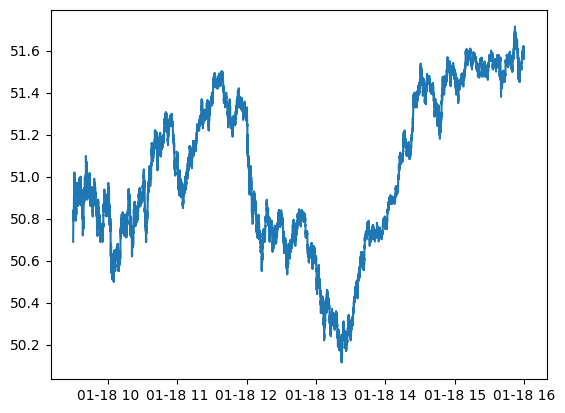

In [30]:
# ticker = "TQQQ"
# _from = "2024-02-05"
# to = "2024-02-06"

# prepared_df = pd.read_pickle(f"prepared_df_1s_{ticker}_{_from}_{to}.pkl")
# cleaned_df = pd.read_pickle(f"cleaned_df_1s_{ticker}_{_from}_{to}.pkl")

test_date = "2024-01-18"
test_data = prepared_df[(prepared_df.index>=pd.to_datetime(test_date))*(prepared_df.index<pd.to_datetime(test_date)+relativedelta(days=1)*(prepared_df.index>=pd.to_datetime(str(test_date) + " " + "09:30:00"))*(prepared_df.index<=pd.to_datetime(str(test_date) + " " + "15:59:59")))]
test_data = test_data[["open", "high", "low", "close", "volume"]]
train_data = cleaned_df[cleaned_df.index<test_data.index[0]]

display(train_data)
display(test_data)
plt.plot(test_data.close)

In [31]:
ttt = pd.DataFrame({
    "close": test_data.close,
    "ema": ta.ema(test_data.close, 12)
    
})
ttt

,close,ema
2024-01-18 09:30:00,50.6900,NaN
2024-01-18 09:30:01,50.7000,NaN
2024-01-18 09:30:02,50.7388,NaN
2024-01-18 09:30:03,50.7200,NaN
2024-01-18 09:30:04,50.7200,NaN
...,...,...
2024-01-18 15:59:55,51.5601,51.585613
2024-01-18 15:59:56,51.5600,51.581673
2024-01-18 15:59:57,51.5600,51.578338
2024-01-18 15:59:58,51.5600,51.575517


In [32]:
ttt.iloc[10:]

,close,ema
2024-01-18 09:30:10,50.7800,NaN
2024-01-18 09:30:11,50.7750,50.748650
2024-01-18 09:30:12,50.7800,50.753473
2024-01-18 09:30:13,50.8200,50.763708
2024-01-18 09:30:14,50.8300,50.773907
...,...,...
2024-01-18 15:59:55,51.5601,51.585613
2024-01-18 15:59:56,51.5600,51.581673
2024-01-18 15:59:57,51.5600,51.578338
2024-01-18 15:59:58,51.5600,51.575517


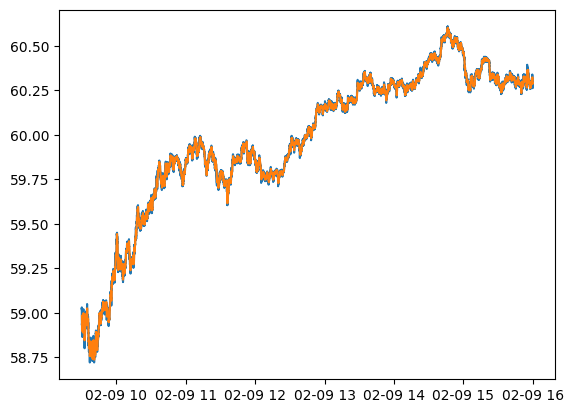

In [12]:
plt.plot(ttt)

2024-02-09 09:30:00          NaN
2024-02-09 09:30:01          NaN
2024-02-09 09:30:02          NaN
2024-02-09 09:30:03          NaN
2024-02-09 09:30:04          NaN
                         ...    
2024-02-09 15:59:55    60.305210
2024-02-09 15:59:56    60.299808
2024-02-09 15:59:57    60.294130
2024-02-09 15:59:58    60.290418
2024-02-09 15:59:59    60.291892
Name: EMA_12, Length: 18022, dtype: float64

In [39]:
pd.to_datetime(test_date)

Timestamp('2024-02-06 00:00:00')

In [40]:
prepared_df

,open,high,low,close,volume,date,time,day
2024-02-05 04:00:00,57.12,57.30,56.93,57.14,2800,2024-02-05,04:00:00,Mon
2024-02-05 04:00:02,57.13,57.13,57.13,57.13,1501,2024-02-05,04:00:02,Mon
2024-02-05 04:00:03,57.16,57.16,57.16,57.16,2027,2024-02-05,04:00:03,Mon
2024-02-05 04:00:10,57.16,57.16,57.16,57.16,270,2024-02-05,04:00:10,Mon
2024-02-05 04:00:29,57.15,57.15,57.14,57.14,1002,2024-02-05,04:00:29,Mon
...,...,...,...,...,...,...,...,...
2024-02-05 19:59:17,57.04,57.04,57.04,57.04,350,2024-02-05,19:59:17,Mon
2024-02-05 19:59:35,57.04,57.04,57.04,57.04,200,2024-02-05,19:59:35,Mon
2024-02-05 19:59:36,57.05,57.05,57.05,57.05,216,2024-02-05,19:59:36,Mon
2024-02-05 19:59:38,57.06,57.06,57.06,57.06,400,2024-02-05,19:59:38,Mon


In [38]:
prepared_df[(prepared_df.index>=pd.to_datetime(test_date))]

,open,high,low,close,volume,date,time,day


In [36]:
prepared_df[(prepared_df.index>=pd.to_datetime(test_date))*(prepared_df.index<pd.to_datetime(test_date)+relativedelta(days=1)*(prepared_df.index>=pd.to_datetime(str(test_date) + " " + "09:30:00"))*(prepared_df.index<=pd.to_datetime(str(test_date) + " " + "15:59:59")))]

,open,high,low,close,volume,date,time,day


# Main

In [12]:
class TechGlobe():
    def __init__(
        self,
        train_data, 
        test_data,
        n_fast_ema=12,
        n_slow_ema=24,
        list_n_time_frames=[15], # Unit: second
        initial_cash=100000,
        n_cut_loss=-0.3, # Unit: Percentage
    ):
        self.train_data = train_data
        self.test_data = test_data
        self.n_fast_ema = n_fast_ema
        self.n_slow_ema = n_slow_ema
        self.list_n_time_frames = list_n_time_frames
        self.initial_cash = initial_cash
        self.n_cut_loss = n_cut_loss/100

    ### Convert to multi time frames data
    def search_update_position(
        self,
        n_time_frames
    ):
        return np.argwhere(n_time_frames==np.array(self.list_n_time_frames))[0][0]

    def convert_existing_data_to_multi_time_frames(
        self
    ):
        ### Convert to other time frame data
        for n_time_frames in self.list_n_time_frames:
            arr_idx = self.existing_data.index[::n_time_frames].values
            arr_open = self.existing_data.open.iloc[::n_time_frames].values
            arr_high = self.existing_data.groupby(np.arange(len(self.existing_data))//n_time_frames).high.max().values
            arr_low = self.existing_data.groupby(np.arange(len(self.existing_data))//n_time_frames).low.min().values
            arr_close = self.existing_data.close.iloc[n_time_frames-1::n_time_frames].values

            selected_position_nth = self.search_update_position(n_time_frames)
            converted_existing_data_multi_time_frames = pd.DataFrame({
                'open': arr_open,
                'high': arr_high,
                'low': arr_low,
                'close': arr_close
            }, index=arr_idx)
             
            self.existing_data_of_multi_time_frames[selected_position_nth] = converted_existing_data_multi_time_frames

    def convert_new_data_to_multi_time_frames(
        self
    ):
        ### Convert 1s time frame to other time frame data
        data_to_convert_time_frame = self.all_new_data.iloc[-self.n_time_frames:, :]

        idx = data_to_convert_time_frame.index[0]
        open_value = data_to_convert_time_frame.open[0]
        high_value = data_to_convert_time_frame.high.max()
        low_value = data_to_convert_time_frame.low.min()
        close_value = data_to_convert_time_frame.close[-1]

        self.converted_new_data_of_multi_time_frames = pd.DataFrame({
            'open': open_value,
            'high': high_value,
            'low': low_value,
            'close': close_value,
            'date_id': self.round_nth_of_multi_time_frames[self.selected_position_nth]
        }, index=[idx])

        ### Update
        self.all_new_data_of_multi_time_frames[self.selected_position_nth] = pd.concat([self.all_new_data_of_multi_time_frames[self.selected_position_nth], self.converted_new_data_of_multi_time_frames])

    def update_existing_data_of_multi_time_frames(
        self
    ):
        self.existing_data_of_multi_time_frames[self.selected_position_nth] = pd.concat([self.existing_data_of_multi_time_frames[self.selected_position_nth], self.converted_new_data_of_multi_time_frames])

    ### For zig zag pattern
    def _identify_initial_pivot(
        self,
        X,
        up_thresh,
        down_thresh
    ):
        """Quickly identify the X[0] as a peak or valley."""
        x_0 = X[0]
        max_x = x_0
        max_t = 0
        min_x = x_0
        min_t = 0
        up_thresh += 1
        down_thresh += 1

        PEAK, VALLEY = 1, -1

        for t in range(1, len(X)):
            x_t = X[t]

            if x_t / min_x >= up_thresh:
                return VALLEY if min_t == 0 else PEAK

            if x_t / max_x <= down_thresh:
                return PEAK if max_t == 0 else VALLEY

            if x_t > max_x:
                max_x = x_t
                max_t = t

            if x_t < min_x:
                min_x = x_t
                min_t = t

        t_n = len(X)-1
        return VALLEY if x_0 < X[t_n] else PEAK

    ### Zig zag indicator
    def peak_valley_pivots_candlestick(
        self,
        close,
        high,
        low,
        up_thresh,
        down_thresh
    ):
        """
        Finds the peaks and valleys of a series of HLC (open is not necessary).
        TR: This is modified peak_valley_pivots function in order to find peaks and valleys for OHLC.
        Parameters
        ----------
        close : This is series with closes prices.
        high : This is series with highs  prices.
        low : This is series with lows prices.
        up_thresh : The minimum relative change necessary to define a peak.
        down_thesh : The minimum relative change necessary to define a valley.
        Returns
        -------
        an array with 0 indicating no pivot and -1 and 1 indicating valley and peak
        respectively
        Using Pandas
        ------------
        For the most part, close, high and low may be a pandas series. However, the index must
        either be [0,n) or a DateTimeIndex. Why? This function does X[t] to access
        each element where t is in [0,n).
        The First and Last Elements
        ---------------------------
        The first and last elements are guaranteed to be annotated as peak or
        valley even if the segments formed do not have the necessary relative
        changes. This is a tradeoff between technical correctness and the
        propensity to make mistakes in data analysis. The possible mistake is
        ignoring data outside the fully realized segments, which may bias analysis.
        """
        if down_thresh > 0:
            raise ValueError('The down_thresh must be negative.')

        initial_pivot = self._identify_initial_pivot(close, up_thresh, down_thresh)

        t_n = len(close)
        pivots = np.zeros(t_n, dtype='i1')
        pivots[0] = initial_pivot

        # Adding one to the relative change thresholds saves operations. Instead
        # of computing relative change at each point as x_j / x_i - 1, it is
        # computed as x_j / x_1. Then, this value is compared to the threshold + 1.
        # This saves (t_n - 1) subtractions.
        up_thresh += 1
        down_thresh += 1

        trend = -initial_pivot
        last_pivot_t = 0
        last_pivot_x = close[0]
        for t in range(1, len(close)):

            if trend == -1:
                x = low[t]
                r = x / last_pivot_x
                if r >= up_thresh:
                    pivots[last_pivot_t] = trend#
                    trend = 1
                    #last_pivot_x = x
                    last_pivot_x = high[t]
                    last_pivot_t = t
                elif x < last_pivot_x:
                    last_pivot_x = x
                    last_pivot_t = t
            else:
                x = high[t]
                r = x / last_pivot_x
                if r <= down_thresh:
                    pivots[last_pivot_t] = trend
                    trend = -1
                    #last_pivot_x = x
                    last_pivot_x = low[t]
                    last_pivot_t = t
                elif x > last_pivot_x:
                    last_pivot_x = x
                    last_pivot_t = t

        if last_pivot_t == t_n-1:
            pivots[last_pivot_t] = trend
        elif pivots[t_n-1] == 0:
            pivots[t_n-1] = trend

        self.selected_zig_zag_data['pivots'] = pivots
        self.selected_zig_zag_data['pivot_price'] = np.nan  # This line clears old pivot prices
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data['pivots'] == 1, 'pivot_price'] = self.selected_zig_zag_data.high
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data['pivots'] == -1, 'pivot_price'] = self.selected_zig_zag_data.low

        ### Fill missing values of zig zag data
        self.compute_and_update_missing_values_of_zig_zag_data()

    ### Compute and update missing values of zig zag indicator for plotting
    def compute_and_update_missing_values_of_zig_zag_data(
        self
    ):
        data_privot_price = self.selected_zig_zag_data[["pivot_price", "date_id"]].copy()
        data_privot_price_without_missing_values = data_privot_price[~data_privot_price.pivot_price.isna()].copy() # Drop missing values

        for i in range(1, len(data_privot_price_without_missing_values)):
            previous_date_id = data_privot_price_without_missing_values.date_id[i-1]
            current_date_id = data_privot_price_without_missing_values.date_id[i]
            diff_date_id = current_date_id-previous_date_id

            previous_pivot_price = data_privot_price_without_missing_values.pivot_price[i-1]
            current_pivot_price = data_privot_price_without_missing_values.pivot_price[i]
            
            if diff_date_id >= 2:
                ### Compute "m (slope)" and "y-intercept"
                m = (current_pivot_price-previous_pivot_price) / (current_date_id-previous_date_id)
                y = data_privot_price_without_missing_values.loc[data_privot_price_without_missing_values.date_id==previous_date_id, 'pivot_price'].values[0]
                x = data_privot_price_without_missing_values.loc[data_privot_price_without_missing_values.date_id==previous_date_id, 'date_id'].values[0]
                y_intercept = y - (m*x)

                ### Fill missing values
                for missing_value_position in range(previous_date_id+1, current_date_id):
                    self.selected_zig_zag_data.loc[self.selected_zig_zag_data.date_id==missing_value_position, 'pivot_price'] = (m*missing_value_position) + y_intercept
        
        ### Update
        self.zig_zag_data_of_multi_time_frames[self.selected_position_nth] = self.selected_zig_zag_data
    
    def verbose(
        self,
        verbose
    ):
        if verbose:
            ### To plot overall
            self.log_data['pivots_buy_signal'] = np.nan
            self.log_data.loc[self.log_data.status=='buy', 'pivots_buy_signal'] = self.log_data.loc[self.log_data.status=='buy', 'open']
            self.log_data['pivots_sell_signal'] = np.nan
            self.log_data.loc[self.log_data.status=='sell', 'pivots_sell_signal'] = self.log_data.loc[self.log_data.status=='sell', 'open']
            self.log_data['pivots_cut_loss_at_the_same_time'] = np.nan
            self.log_data.loc[self.log_data.status=='cut_loss_at_the_same_time', 'pivots_sell_signal'] = self.log_data.loc[self.log_data.status=='cut_loss_at_the_same_time', 'open']
            self.log_data['pivots_cut_loss_at_the_other_time'] = np.nan
            self.log_data.loc[self.log_data.status=='cut_loss_at_the_other_time', 'pivots_sell_signal'] = self.log_data.loc[self.log_data.status=='cut_loss_at_the_other_time', 'open']

            display(self.log_data.loc[self.log_data.IsEMACuttingDown==1, 'date_id'])

            ### Check
            print(f"({self.round_nth}) Current timing: {self.current_time}, Interface: {self.IsInterface}_{self.cycle_nth}")
            print(f"Status: {self.log_data.loc[self.current_time, 'status']}")
            if self.IsCutLoss == 1:
                # print(f"self.current_pct_change_of_open_and_low <= self.n_cut_loss: {self.current_pct_change_of_open_and_low <= self.n_cut_loss}")
                print(f"Current pct change of open and low: {np.round(self.current_pct_change_of_open_and_low*100, 4)}%")
            elif self.IsCutLoss == 2:
                print(f"self.reference_cash_at_the_buy_timing: {self.reference_cash_at_the_buy_timing}")
                print(f"(self.log_data.loc[self.current_time, 'holding']/self.reference_cash_at_the_buy_timing)-1: {(self.log_data.loc[self.current_time, 'holding']/self.reference_cash_at_the_buy_timing)-1}")
            print(f"Bullets: {self.log_data.loc[self.current_time, 'bullets']}")
            print(f"Holding: {self.log_data.loc[self.current_time, 'holding']}")
            print(f"NAV: {self.log_data.loc[self.current_time, 'nav']}")
            try:
                profit_or_loss_pct = ((self.log_data.loc[self.current_time, 'nav']/self.reference_cash_at_the_buy_timing)-1)*100
                if self.log_data.loc[self.current_time, 'status'] != 'waiting':
                    print(f"Profit/Loss: {np.round(profit_or_loss_pct, 4)}% (Reference cash at the buy timing: {self.reference_cash_at_the_buy_timing})")
            except:
                pass
            if self.IsBuySignal == 1:
                ### Check
                print("Occur: Buy signal")
                self.plot_overall()
                # display(self.data_positive_pivots)
                # display(self.data_negative_pivots)
                print(f"LL timing: {self.ll_timing} (LL value: {self.ll_value})")
                print(f"HH timing: {self.hh_timing_of_buy_signal}")
                print(f"HL timing: {self.hl_timing} (HL value: {self.hl_value})")
            if self.IsSellSignal == 1:
                print(f"Occur: Sell signal")
                if self.IsEMACuttingDown == 0:
                    print(f"'coz: LL -> HH -> LH")
                else: # self.IsEMACuttingDown == 1
                    print(f"'coz: EMA cutting down")
                self.plot_overall()
                # display(self.data_positive_pivots)
                # display(self.data_negative_pivots)
                print(f"self.ll_timing: {self.ll_timing}, ll_value: {self.ll_value}")
                print(f"self.hh_timing_of_sell_signal: {self.hh_timing_of_sell_signal}")
                print(f"self.lh_timing: {self.lh_timing}, lh_value: {self.lh_value}")
            print("-"*100)

    ### [Opt.] Compute EMA
    def compute_ema(
        self
    ):
        fast_ema = ta.ema(self.selected_existing_data.close, self.n_fast_ema)[-1]
        slow_ema = ta.ema(self.selected_existing_data.close, self.n_slow_ema)[-1]

        ### Update
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, f"ema_{self.n_fast_ema}"] = fast_ema
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, f"ema_{self.n_slow_ema}"] = slow_ema

    ### Search AB interfaces
    def search_ab_interfaces(
        self
    ):
        fast_ema = self.selected_all_new_data[f"ema_{self.n_fast_ema}"].iloc[-1]
        slow_ema = self.selected_all_new_data[f"ema_{self.n_slow_ema}"].iloc[-1]

        ### Select AB interface
        if self.selected_round_nth == 0:
            if fast_ema > slow_ema:
                self.IsInterface = 'A'
            elif fast_ema < slow_ema:
                self.IsInterface = 'B'
            else:
                assert False, "fast_ema == slow_ema"

        ### Update
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'interface'] = self.IsInterface + f"_{self.cycle_nth}"

    ### Search EMA cutting down
    def search_ema_cutting_down(
        self
    ):
        if len(self.selected_all_new_data) <= 1:
            IsEMACutting = np.nan
            cutting_deg = np.nan
            self.IsEMACuttingDown = np.nan
            
        else: # len(self.selected_all_new_data) >= 2
            fast_ema_line = self.selected_all_new_data[f"ema_{self.n_fast_ema}"].iloc[-2:].values
            slow_ema_line = self.selected_all_new_data[f"ema_{self.n_slow_ema}"].iloc[-2:].values
            IsEMACutting = np.diff(np.sign(fast_ema_line- slow_ema_line))[0] == -2 # Cutting=-2, Not cutting= ### [0] to get a value, -2 to convert number to bool
            cutting_deg = math.degrees(math.atan(np.diff(fast_ema_line)))

            self.IsEMACuttingDown = 0
            if IsEMACutting == True and cutting_deg<0:
                self.IsEMACuttingDown = 1
                self.ema_cutting_down_time = self.current_time_of_multi_time_frames

                self.cycle_nth += 1

        ### Update
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsEMACutting'] = IsEMACutting
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'cutting_deg'] = cutting_deg
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsEMACuttingDown'] = self.IsEMACuttingDown

        if self.IsEMACuttingDown == 1:
            self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'cutting_down_time'] = self.ema_cutting_down_time

    def compute_pivots_for_plotting(
        self
    ):
        self.selected_zig_zag_data["pivot_ll"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==-2, 'pivot_ll'] = self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==-2, 'low']
        self.selected_zig_zag_data["pivot_hl"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==-1, 'pivot_hl'] = self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==-1, 'low']
        self.selected_zig_zag_data["pivot_hh"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==2, 'pivot_hh'] = self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==2, 'high']
        self.selected_zig_zag_data["pivot_lh"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==1, 'pivot_lh'] = self.selected_zig_zag_data.loc[self.selected_zig_zag_data.pivots==1, 'high']

        self.selected_zig_zag_data["pivot_buy_signal"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_all_new_data.status=='buy', 'pivot_buy_signal'] = self.selected_zig_zag_data.loc[self.selected_all_new_data.status=='buy', 'low']
        self.selected_zig_zag_data["pivot_sell_signal"] = np.nan
        self.selected_zig_zag_data.loc[self.selected_all_new_data.status=='sell', 'pivot_sell_signal'] = self.selected_zig_zag_data.loc[self.selected_all_new_data.status=='sell', 'high']

    def search_ll_and_hl(
        self,
    ):
        self.IsLL = 0
        self.IsHL = 0

        if self.n_negative_pivots >= 1:
            self.IsLL = 1
            
            if self.n_negative_pivots == 1:
                self.ll_time = self.data_negative_pivots[self.data_negative_pivots.low==self.data_negative_pivots.low.min()].index[0]
                self.ll_value = self.data_negative_pivots.loc[self.ll_time, 'low']

            elif self.n_negative_pivots >= 2:
                self.IsHL = 1
                self.previous_negative_pivot_time = self.data_negative_pivots.index[-2]
                self.current_negative_pivot_time = self.data_negative_pivots.index[-1]
                self.previous_negative_pivot_value = self.data_negative_pivots.low[-2]
                self.current_negative_pivot_value = self.data_negative_pivots.low[-1]

                if self.current_negative_pivot_value < self.previous_negative_pivot_value:
                    self.ll_time = self.current_negative_pivot_time
                    self.ll_value = self.current_negative_pivot_value
                    self.hl_time = self.previous_negative_pivot_time
                    self.hl_value = self.previous_negative_pivot_value
                elif self.current_negative_pivot_value > self.previous_negative_pivot_value:
                    self.ll_time = self.previous_negative_pivot_time
                    self.ll_value = self.previous_negative_pivot_value
                    self.hl_time = self.current_negative_pivot_time
                    self.hl_value = self.current_negative_pivot_value
                else:
                    self.IsLL = 0
                    self.IsHL = 0

                # print(f"self.ll_value: {self.ll_value}, self.ll_time: {self.ll_time}")
                # print(f"self.hl_value: {self.hl_value}, self.hl_time: {self.hl_time}")

        ### Update
        self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'IsLL'] = self.IsLL
        self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'IsHL'] = self.IsHL

        if self.IsLL == 1:
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'll_time'] = self.ll_time
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'll_value'] = self.ll_value
            
            self.selected_zig_zag_data.loc[self.selected_zig_zag_data.index==self.ll_time, 'pivots'] = -2

        if self.IsHL == 1:
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'hl_time'] = self.hl_time
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'hl_value'] = self.hl_value

            if self.current_negative_pivot_value < self.previous_negative_pivot_value:
                self.selected_zig_zag_data.loc[(self.selected_zig_zag_data.index<self.ll_time)*(self.selected_zig_zag_data.pivots==-2), 'pivots'] = -1  # -1: Because found new ll

    def search_hh_and_lh(
        self
    ):
        self.IsHH = 0
        self.IsLH = 0

        if self.n_positive_pivots >= 1:
            self.IsHH = 1
            
            if self.n_positive_pivots == 1:
                self.hh_time = self.data_positive_pivots[self.data_positive_pivots.high==self.data_positive_pivots.high.max()].index[0]
                self.hh_value = self.data_positive_pivots.loc[self.hh_time, 'high']
                
            elif self.n_positive_pivots >= 2:
                self.IsLH = 1
                self.previous_positive_pivot_time = self.data_positive_pivots.index[-2]
                self.previous_positive_pivot_value = self.data_positive_pivots.high[-2]
                self.current_positive_pivot_time = self.data_positive_pivots.index[-1]
                self.current_positive_pivot_value = self.data_positive_pivots.high[-1]

                if self.current_positive_pivot_value > self.previous_positive_pivot_value:
                    self.hh_time = self.current_positive_pivot_time
                    self.hh_value = self.current_positive_pivot_value
                    self.lh_time = self.previous_positive_pivot_time
                    self.lh_value = self.previous_positive_pivot_value
                elif self.current_positive_pivot_value < self.previous_positive_pivot_value:
                    self.hh_time = self.previous_positive_pivot_time
                    self.hh_value = self.previous_positive_pivot_value
                    self.lh_time = self.current_positive_pivot_time
                    self.lh_value = self.current_positive_pivot_value
                else:
                    self.IsHH = 0
                    self.IsLH = 0

                # print(f"self.hh_value: {self.hh_value}, self.hh_time: {self.hh_time}")
                # print(f"self.lh_value: {self.lh_value}, self.lh_time: {self.lh_time}")

        ### Update
        self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'IsHH'] = self.IsHH
        self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'IsLH'] = self.IsLH

        if self.IsHH == 1:
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'hh_time'] = self.hh_time
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'hh_value'] = self.hh_value
            
            self.selected_zig_zag_data.loc[self.selected_zig_zag_data.index==self.hh_time, 'pivots'] = 2

        if self.IsLH == 1:
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'lh_time'] = self.lh_time
            self.selected_all_new_data.loc[self.selected_all_new_data.index==self.current_time_of_multi_time_frames, 'lh_value'] = self.lh_value

            if self.current_positive_pivot_value > self.previous_positive_pivot_value:
                self.selected_zig_zag_data.loc[(self.selected_zig_zag_data.index<self.hh_time)*(self.selected_zig_zag_data.pivots==2), 'pivots'] = 1 # 1: Because found new hh

    def search_buy_signal_v_1(
        self
    ):
        if self.sub_version==1 or self.sub_version==2 or self.sub_version==3 or self.sub_version==4 or self.sub_version==5:
            if self.IsHL==1 and self.IsHH==1 and self.IsLL==1 and self.IsLH==1:
                if self.hl_time > self.hh_time and self.hh_time > self.ll_time and self.ll_time > self.lh_time:
                    self.IsBuySignal = 1
                else:
                    self.IsBuySignal = 0
            else:
                self.IsBuySignal = 0

        ### Update
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsBuySignal'] = self.IsBuySignal

    def search_sell_signal_v_1(
        self
    ):
        if self.sub_version == 1:
            if self.IsLH==1 and self.IsHH==1 and self.IsLL==1 and self.IsHL==1:
                if self.lh_time > self.hl_time and self.hl_time > self.hh_time and self.hh_time > self.ll_time:
                    self.IsSellSignal = 1
                elif self.lh_time > self.ll_time and self.ll_time > self.hh_time and self.hh_time > self.hl_time:
                    self.IsSellSignal = 1
                else:
                    self.IsSellSignal = 0
            else:
                self.IsSellSignal = 0

        elif self.sub_version == 2:
            if self.IsEMACuttingDown == 1:
                self.IsSellSignal = 1
            else:
                self.IsSellSignal = 0

        elif self.sub_version == 3:
            if self.IsLH==1 and self.IsHH==1 and self.IsLL==1 and self.IsHL==1:
                if self.lh_time > self.hl_time and self.hl_time > self.hh_time and self.hh_time > self.ll_time:
                    self.IsSellSignal = 1
                elif self.lh_time > self.ll_time and self.ll_time > self.hh_time and self.hh_time > self.hl_time:
                    self.IsSellSignal = 1
                else:
                    self.IsSellSignal = 0
            elif self.IsEMACuttingDown == 1:
                self.IsSellSignal = 1
            else:
                self.IsSellSignal = 0

        elif self.sub_version == 4:
            if self.IsLH==1 and self.IsHH==1 and self.IsLL==1 and self.IsHL==1:
                if (self.lh_time > self.hl_time and self.hl_time > self.hh_time and self.hh_time > self.ll_time) or (self.lh_time > self.ll_time and self.ll_time > self.hh_time and self.hh_time > self.hl_time):
                    IsPseudoSellSignal = 1
                else:
                    IsPseudoSellSignal = 0
            else:
                IsPseudoSellSignal = 0

            ### Update psuedo sell signal
            self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsPseudoSellSignal'] = IsPseudoSellSignal

            if self.IsEMACuttingDown == 1:
                pseudo_sell_signal_data = self.selected_all_new_data.loc[self.selected_all_new_data.IsPseudoSellSignal==1]
                n_pseudo_sell_signal = len(pseudo_sell_signal_data)
                
                if n_pseudo_sell_signal >= 1:
                    self.IsSellSignal = 1
                else:
                    self.IsSellSignal = 0
            else:
                self.IsSellSignal = 0

        elif self.sub_version == 5:
            pseudo_sell_signal_data = self.selected_all_new_data.loc[self.selected_all_new_data.IsEMACuttingDown==1]
            n_pseudo_sell_signal = len(pseudo_sell_signal_data)

            if n_pseudo_sell_signal >= 1:
                if self.IsLH==1 and self.IsHH==1 and self.IsLL==1 and self.IsHL==1:
                    if (self.lh_time > self.hl_time and self.hl_time > self.hh_time and self.hh_time > self.ll_time) or (self.lh_time > self.ll_time and self.ll_time > self.hh_time and self.hh_time > self.hl_time):
                        self.IsSellSignal = 1
                    else:
                        self.IsSellSignal = 0
                else:
                    self.IsSellSignal = 0
            else:
                self.IsSellSignal = 0

        ### Update the sell signal
        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsSellSignal'] = self.IsSellSignal

    def strategy_v_1(
        self
    ):
        # self.selected_zig_zag_data = self.zig_zag_data_of_multi_time_frames[0]
        self.selected_zig_zag_data = self.zig_zag_data_of_multi_time_frames[self.selected_position_nth]
        self.data_positive_pivots = self.selected_zig_zag_data[(self.selected_zig_zag_data.pivots == 1)*(self.selected_zig_zag_data.interface == f"{self.IsInterface}_{self.cycle_nth}")]
        self.data_negative_pivots = self.selected_zig_zag_data[(self.selected_zig_zag_data.pivots == -1)*(self.selected_zig_zag_data.interface == f"{self.IsInterface}_{self.cycle_nth}")]
        self.n_positive_pivots = len(self.data_positive_pivots)
        self.n_negative_pivots = len(self.data_negative_pivots)

        if self.selected_round_nth == 0:
            self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsBuySignal'] = 0
            self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsSellSignal'] = 0
            self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "waiting"

        ### Search LL and HL
        self.search_ll_and_hl()
        ### Search HH and LH
        self.search_hh_and_lh()

        ### Search buy signal
        self.search_buy_signal_v_1()
        ### Search sell signal
        self.search_sell_signal_v_1()

        # print(f"self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsBuySignal']: {self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsBuySignal']}")
        # print(f"self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsSellSignal']: {self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsSellSignal']}")
        # print(f"self.IsEMACuttingDown: {self.IsEMACuttingDown}")

    ### Plot
    def plot(
        self
    ):
        ### Colors
        g_03 = "#A2D9CE"
        g_06 = "#16A085"
        g_10 = "#0B5345"

        r_03 = "#F5B7B1"
        r_06 = "#E74C3C"
        r_10 = "#78281F"

        b_06 = "#3498DB"
        orange_06 = "#F39C12"

        ### Setup
        n_above_percentage = 0.5 # Unit: percentage
        n_below_percentage = 0.5 # Unit: percentage
        below_percentage = 1-(n_above_percentage/100)
        above_percentage = 1+(n_below_percentage/100)
        below_above_percentage = above_percentage*(1-0.0025)
        above_below_percentage = below_percentage*(1+0.0025)

        mc = mpf.make_marketcolors(
            up='green', 
            down='red', 
            edge='black', 
            volume='gray'
        )

        s = mpf.make_mpf_style(
            marketcolors=mc,
            gridcolor='lightgray',
            gridstyle=':',
            # facecolor='#a9a9a9',
            # figcolor='#a9a9a9',
            y_on_right=False
        )

        fig = mpf.figure(style=s, figsize=(7, 4))

        ax1 = fig.add_subplot(6, 1, (1, 4), style=s)
        ax2 = fig.add_subplot(6, 1, (5, 6), style=s, sharex=ax1)
        ax1.tick_params(labelbottom=False)
        # ax2.tick_params(labelbottom=False)

        plots = [
            ### ax1
            mpf.make_addplot(self.selected_zig_zag_data['pivot_price'], ax=ax1, color='purple', width=1),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_ll']*below_percentage, scatter=True, marker="$LL$", markersize=150, ax=ax1, color=g_06),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_hl']*below_percentage, scatter=True, marker="$HL$", markersize=150, ax=ax1, color=g_06),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_hh']*above_percentage, scatter=True, marker="$HH$", markersize=150, ax=ax1, color=r_06),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_lh']*above_percentage, scatter=True, marker="$LH$", markersize=150, ax=ax1, color=r_06),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_buy_signal']*above_below_percentage, type="scatter", marker="^", markersize=150, ax=ax1, color=g_06),
            mpf.make_addplot(self.selected_zig_zag_data['pivot_sell_signal']*below_above_percentage, type="scatter", marker="v", markersize=150, ax=ax1, color=r_06),
            # mpf.make_addplot(self.log_data['pivots_cut_loss_at_the_same_time'], type="scatter", marker="v", markersize=200, ax=ax1, color=orange_06),
            # mpf.make_addplot(self.log_data['pivots_cut_loss_at_the_other_time'], type="scatter", marker="v", markersize=200, ax=ax1, color=orange_06),

            ### ax2
            mpf.make_addplot(self.selected_all_new_data[f'ema_{self.n_fast_ema}'], ax=ax2, color='red', width=1),
            mpf.make_addplot(self.selected_all_new_data[f'ema_{self.n_slow_ema}'], ylabel=f"EMA{self.n_fast_ema} (R) & EMA{self.n_slow_ema} (B)", ax=ax2, color='blue', width=1),
        ]

        ### To determine y lim
        ymin = self.selected_all_new_data['low'].min()*below_percentage*(1-0.003)
        ymax = self.selected_all_new_data['high'].max()*above_percentage*(1+0.003)

        chart_setup = dict(type='candle', ax=ax1, volume=False)

        mpf.plot(
            self.selected_all_new_data,
            **chart_setup,
            style=s,
            addplot=plots,
            xrotation=7,
            # tight_layout=True,
            tight_layout=False,
            # datetime_format="%d-%b-%y %H:%M:%S",
            datetime_format="%H:%M:%S",
            returnfig=True,
            ylim=(ymin, ymax)
        )
        
        ### EMA cutting down
        list_date_id_of_ema_cutting_down = self.selected_all_new_data[self.selected_all_new_data.IsEMACuttingDown==1].date_id.values
        if len(list_date_id_of_ema_cutting_down) >= 1:
            for ax in [ax1, ax2]:
                for x in list_date_id_of_ema_cutting_down:
                    ax.axvline(x=x, linestyle='--', color=r_06, alpha=0.75)


        if self.show_plot:
            ### Adjustments to plot
            plt.subplots_adjust(hspace=0)
            mpf.show()
        else:
            plt.close('all')



        ### Save plot
        if self.save_plot:
            plt.savefig(f'{self.file_name}/{self.round_nth}.png')

    def check_and_update_missing_times(
        self
    ):
        try:
            n_missing_times = (self.all_new_data.index[-1]-self.all_new_data.index[-2]).seconds - 1

            if n_missing_times >= 1:
                for m_t in range(n_missing_times):
                    missing_time = self.all_new_data.index[-2] + relativedelta(seconds=1)
                    missing_data = self.all_new_data.loc[self.all_new_data.index<missing_time].tail(14).mean().to_frame().T
                    missing_data.index = [missing_time] # Change index
                    self.all_new_data = pd.concat([self.all_new_data, missing_data]) # Update all new data
                    self.all_new_data.sort_index(inplace=True)
                    
        except:
            pass

    def check_and_update_status(
        self
    ):
        if self.selected_round_nth >= 1:
            if self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsBuySignal'] == 0 and self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']!="holding":
                if self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsSellSignal'] == 1 and self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status'] == 'buy':
                    self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "sell"
                elif self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsSellSignal'] == 0 and self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status'] == 'buy':
                    self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "holding"
                else:
                    self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "waiting"
            
            else: # self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsBuySignal'] == 1
                if self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsSellSignal'] == 0:
                    if self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="waiting" and self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']!="holding":
                        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "buy"
                    
                    elif self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="buy" or self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="holding":
                        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "holding"
                    
                    # elif self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="cut_loss_at_the_same_time" or self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="cut_loss_at_the_other_time":
                    #     self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "waiting"

                else: # self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'IsSellSignal'] == 1
                    if self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="buy" or self.selected_all_new_data.loc[self.previous_time_of_multi_time_frames, 'status']=="holding":
                        self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "sell"

    def create_folder(
        self
    ):
        if self.save_plot:
            try:
                self.file_name = f"plot__main_version_{self.main_version}__sub_version_{self.sub_version}__up_thresh_{self.up_thresh}__down_thresh_{self.down_thresh}"
                os.mkdir(self.file_name)
            except:
                pass

    def update_log_data(
        self
    ):
        dict_re_column_names = {col_name: f"{col_name}__{self.n_time_frames}" for col_name in self.selected_all_new_data.columns}
        selected_all_new_data_for_log = self.selected_all_new_data.tail(1).rename(columns=dict_re_column_names)
        selected_all_new_series_for_log = selected_all_new_data_for_log.squeeze(axis=0)
        if len(self.log_data) == 0:
            self.log_data = pd.concat([self.log_data, selected_all_new_data_for_log], axis=0)
        else:
            try:
                if selected_all_new_data_for_log.index[0] not in self.log_data.index:
                    self.log_data = pd.concat([self.log_data, selected_all_new_data_for_log], axis=0)
                else:
                    self.log_data = pd.concat([self.log_data, selected_all_new_data_for_log], axis=1)
            except:
                self.log_data.loc[selected_all_new_series_for_log.name] = selected_all_new_series_for_log

    def compute_nav(
        self
    ):
        maker_fees = 0.001 # usd per share
        taker_fees = 0.001 # usd per share

        ### Update all new data for log
        self.nav_data = pd.concat([self.nav_data, self.all_new_data.tail(1)])
        self.nav_data['_pct_change'] = self.nav_data.open.pct_change()
        self.current_time = self.nav_data.index[-1]

        if self.round_nth == 0:
            self.nav_data.loc[self.current_time, 'bullets'] = self.initial_cash
            self.nav_data.loc[self.current_time, 'holding'] = 0
            self.nav_data.loc[self.current_time, 'status'] = 'waiting'
        else:
            previous_bullets = self.nav_data.bullets[-2]
            self.previous_time = self.nav_data.index[-2]
            try:
                if self.log_data[f"IsBuySignal__{self.list_n_time_frames[0]}"][-1] == 1:
                    if self.nav_data.loc[self.previous_time, 'status'] == 'waiting':
                        self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                        self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding']        
                        self.nav_data.loc[self.current_time, 'status'] = 'ready_to_buy'

                    elif self.nav_data.loc[self.previous_time, 'status'] == 'ready_to_buy':
                        if previous_bullets-self.initial_cash >= 0:
                            commission = (self.initial_cash/self.nav_data.loc[self.current_time, 'open']) * maker_fees
                            self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets-self.initial_cash
                            self.nav_data.loc[self.current_time, 'holding'] = self.initial_cash - commission
                            self.nav_data.loc[self.current_time, 'status'] = 'buy'
                            self.reference_cash_at_the_buy_timing = self.initial_cash

                            self.nav_data.loc[self.current_time, 'commission'] = commission
                        else:
                            commission = (previous_bullets/self.nav_data.loc[self.current_time, 'open']) * maker_fees
                            self.nav_data.loc[self.current_time, 'bullets'] = 0
                            self.nav_data.loc[self.current_time, 'holding'] = previous_bullets - commission
                            self.nav_data.loc[self.current_time, 'status'] = 'buy'
                            self.reference_cash_at_the_buy_timing = previous_bullets

                            self.nav_data.loc[self.current_time, 'commission'] = commission

                    elif self.nav_data.loc[self.previous_time, 'status'] == 'buy' or self.nav_data.loc[self.previous_time, 'status'] == 'holding':
                        self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                        self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                        self.nav_data.loc[self.current_time, 'status'] = 'holding'
                        pnl = self.nav_data.loc[self.current_time, 'holding'] - self.reference_cash_at_the_buy_timing
                        self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'holding']/self.reference_cash_at_the_buy_timing) - 1

                elif self.log_data[f"status__{self.list_n_time_frames[0]}"][-1] == 'buy' and (self.nav_data.loc[self.previous_time, 'status'] == 'holding'):
                    self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                    self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                    self.nav_data.loc[self.current_time, 'status'] = 'holding'
                    pnl = self.nav_data.loc[self.current_time, 'holding'] - self.reference_cash_at_the_buy_timing
                    self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'holding']/self.reference_cash_at_the_buy_timing) - 1

                elif self.log_data[f"status__{self.list_n_time_frames[0]}"][-1] == 'holding' and self.nav_data.loc[self.previous_time, 'status'] == 'holding' and self.log_data[f"IsSellSignal__{self.list_n_time_frames[0]}"][-1] != 1:
                    self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                    self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                    self.nav_data.loc[self.current_time, 'status'] = 'holding'
                    pnl = self.nav_data.loc[self.current_time, 'holding'] - self.reference_cash_at_the_buy_timing
                    self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'holding']/self.reference_cash_at_the_buy_timing) - 1

                elif (self.log_data[f"IsSellSignal__{self.list_n_time_frames[0]}"][-1] == 1 and self.nav_data.loc[self.previous_time, 'status'] != 'sell' and self.nav_data.loc[self.previous_time, 'status'] != 'waiting'):
                    if self.nav_data.loc[self.previous_time, 'status'] == 'holding':
                        self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                        self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                        self.nav_data.loc[self.current_time, 'status'] = 'ready_to_sell'
                    elif self.nav_data.loc[self.previous_time, 'status'] == 'ready_to_sell':
                        commission = (self.nav_data.loc[self.previous_time, 'holding']/self.nav_data.loc[self.current_time, 'open']) * taker_fees
                        self.nav_data.loc[self.current_time, 'holding'] = 0
                        self.nav_data.loc[self.current_time, 'bullets'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1) - commission
                        self.nav_data.loc[self.current_time, 'status'] = 'sell'
                        pnl = self.nav_data.loc[self.current_time, 'bullets'] - self.reference_cash_at_the_buy_timing
                        self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'bullets']/self.reference_cash_at_the_buy_timing) - 1

                        self.nav_data.loc[self.current_time, 'commission'] = commission

                elif self.log_data[f"status__{self.list_n_time_frames[0]}"][-1] == 'sell' and (self.nav_data.loc[self.previous_time, 'status'] == 'holding'):
                    self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                    self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                    self.nav_data.loc[self.current_time, 'status'] = 'ready_to_sell'
                    pnl = self.nav_data.loc[self.current_time, 'bullets'] - self.reference_cash_at_the_buy_timing
                    self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'bullets']/self.reference_cash_at_the_buy_timing) - 1

                elif self.nav_data.loc[self.previous_time, 'status'] == 'ready_to_sell':
                    commission = (self.nav_data.loc[self.previous_time, 'holding']/self.nav_data.loc[self.current_time, 'open']) * taker_fees
                    self.nav_data.loc[self.current_time, 'holding'] = 0
                    self.nav_data.loc[self.current_time, 'bullets'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1) - commission
                    self.nav_data.loc[self.current_time, 'status'] = 'sell'
                    pnl = self.nav_data.loc[self.current_time, 'bullets'] - self.reference_cash_at_the_buy_timing
                    self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'bullets']/self.reference_cash_at_the_buy_timing) - 1
                    
                    self.nav_data.loc[self.current_time, 'commission'] = commission


                # elif self.log_data[f"status__{self.list_n_time_frames[0]}"][-1] == 'sell' and self.nav_data.loc[self.previous_time, 'status'] == 'holding':
                #     self.nav_data.loc[self.current_time, 'holding'] = 0
                #     self.nav_data.loc[self.current_time, 'bullets'] = self.nav_data.loc[self.previous_time, 'holding'] * (self.nav_data.loc[self.current_time, '_pct_change'] + 1)
                #     self.nav_data.loc[self.current_time, 'status'] = 'sell'
                #     pnl = self.nav_data.loc[self.current_time, 'bullets'] - self.reference_cash_at_the_buy_timing
                #     self.pnl_pct_change = (self.nav_data.loc[self.current_time, 'bullets']/self.reference_cash_at_the_buy_timing) - 1
                
                else: # self.log_data[f"status__{self.list_n_time_frames[0]}"][-1] == 'waiting'
                    self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                    self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding']
                    self.nav_data.loc[self.current_time, 'status'] = 'waiting'

            except: # Incase, There're no multi time frames data
                self.nav_data.loc[self.current_time, 'bullets'] = previous_bullets
                self.nav_data.loc[self.current_time, 'holding'] = self.nav_data.loc[self.previous_time, 'holding']
                self.nav_data.loc[self.current_time, 'status'] = self.nav_data.loc[self.previous_time, 'status']

        ### Update
        # if len(self.all_new_data) % self.list_n_time_frames[0] == 0:
        #     self.log_data.loc[self.current_time_of_multi_time_frames, 'bullets'] = self.nav_data.loc[self.current_time, 'bullets']
        #     self.log_data.loc[self.current_time_of_multi_time_frames, 'holding'] = self.nav_data.loc[self.current_time, 'holding']
        #     try:
        #         self.log_data.loc[self.current_time_of_multi_time_frames, 'pnl'] = pnl
        #         self.log_data.loc[self.current_time_of_multi_time_frames, 'pnl_pct_change'] = self.pnl_pct_change
        #     except:
        #         pass

        try:
            self.nav_data.loc[self.current_time, 'pnl'] = pnl
            self.nav_data.loc[self.current_time, 'pnl_pct_change'] = self.pnl_pct_change
        except:
            pass

        ### Check
        print(f"({self.round_nth}) current time: {self.current_time}")
        try:
            print(f"self.current_time_of_multi_time_frames: {self.current_time_of_multi_time_frames}")
            print(f'self.log_data.IsBuySignal__15[-1]: {self.log_data.IsBuySignal__15[-1]}')
            print(f'self.log_data.IsSellSignal__15[-1]: {self.log_data.IsSellSignal__15[-1]}')
            print(f'self.log_data.IsEMACuttingDown__15[-1]: {self.log_data.IsEMACuttingDown__15[-1]}')
        except:
            pass
        print(f"status: {self.nav_data.loc[self.current_time, 'status']}")
        print(f"bullets: {self.nav_data.loc[self.current_time, 'bullets']}")
        print(f"holding: {self.nav_data.loc[self.current_time, 'holding']}")
        try:
            print(f"commission: {commission}")
        except:
            pass
        try:
            print(f"pnl: {np.round(pnl, 4)}")
            print(f"pnl_pct: {np.round(self.pnl_pct_change*100, 4)}%")
            print(f"o: {np.round(self.nav_data.loc[self.current_time, 'open'], 4)}, h: {np.round(self.nav_data.loc[self.current_time, 'high'], 4)}, l: {np.round(self.nav_data.loc[self.current_time, 'low'], 4)}, c: {np.round(self.nav_data.loc[self.current_time, 'close'], 4)}, pct_change: {np.round(self.nav_data.loc[self.current_time, '_pct_change']*100, 4)}%")
        except:
            pass
        print()

    # def cut_loss(
    #     self
    # ):
    #     if self.n_cut_loss != 0:
    #         try:
    #             if self.pnl_pct_change <= self.n_cut_loss:
    #                 self.IsCutLoss = 1
    #             else:
    #                 self.IsCutLoss = 0
    #         except:
    #             self.IsCutLoss = 0

    #     if self.IsCutLoss == 1:

    #         self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'IsCutLoss'] = self.IsCutLoss
    #         self.selected_all_new_data.loc[self.current_time_of_multi_time_frames, 'status'] = "sell"


    #         if self.log_data.loc[self.current_time, 'status'] == 'buy' or self.log_data.loc[self.current_time, 'status'] == 'holding':
    #             current_open_price = self.log_data.loc[self.current_time, 'open']
    #             current_low_price = self.log_data.loc[self.current_time, 'low']
    #             self.current_pct_change_of_open_and_low = (current_low_price/current_open_price)-1

    #             previous_open_price = self.log_data.loc[self.previous_time, 'open']
                
    #             if self.current_pct_change_of_open_and_low <= self.n_cut_loss:
    #                 self.IsCutLoss = 1
    #             elif (self.log_data.loc[self.current_time, 'nav']/self.reference_cash_at_the_buy_timing)-1 <= self.n_cut_loss:
    #                 self.IsCutLoss = 2
    #             else:
    #                 self.IsCutLoss = 0
    #         else:
    #             self.IsCutLoss = 0
    #     else:
    #         self.IsCutLoss = 0

    #     ### Update
    #     self.log_data.loc[self.current_time, 'IsCutLoss'] = self.IsCutLoss

    #     if self.IsCutLoss == 0:
    #         pass
    #     else:
    #         if self.IsCutLoss == 1:
    #             self.log_data.loc[self.current_time, 'status'] = 'cut_loss_at_the_same_time'
    #             # self.compute_nav()
    #         else: # IsCutLoss == 2
    #             self.log_data.loc[self.current_time, 'status'] = 'cut_loss_at_the_other_time'
            
    #         self.compute_nav()

    def run_strategy(
        self,
        main_version = 1,
        sub_version = 3,
        today_date = "2024-01-18",
        up_thresh = 0.001,
        down_thresh = -0.001,
        verbose=False,
        show_plot=False,
        save_plot=False,
    ):
        self.main_version = main_version
        self.sub_version = sub_version
        self.show_plot = show_plot
        self.save_plot = save_plot
        self.up_thresh = up_thresh
        self.down_thresh = down_thresh

        ### Create a folder
        self.create_folder()

        ### All data
        self.existing_data = self.train_data.copy()
        self.all_new_data = pd.DataFrame()
        self.nav_data = pd.DataFrame()

        self.existing_data_of_multi_time_frames = [pd.DataFrame() for i in range(len(self.list_n_time_frames))] 
        self.convert_existing_data_to_multi_time_frames() # Convert existing data to multi time frames
        self.all_new_data_of_multi_time_frames = [pd.DataFrame() for i in range(len(self.list_n_time_frames))]
        self.zig_zag_data_of_multi_time_frames = [pd.DataFrame() for i in range(len(self.list_n_time_frames))]
        
        self.cycle_nth = 1 # To count the cycle
        self.round_nth = 0 # To select the cycle
        self.update_interfece_nth = 1 # To update the interface
        self.round_nth_of_multi_time_frames = [0 for i in range(len(self.list_n_time_frames))]

        self.log_data = pd.DataFrame()

        for i in range(len(test_data)):
        # for i in range(15+1):
        # for i in range(10252+1):
        # for i in range(11010+1):
            new_data = self.test_data.iloc[i].to_frame().T # New data

            ### Update data
            self.all_new_data = pd.concat([self.all_new_data, new_data]) # Update all new data
            self.existing_data = pd.concat([self.existing_data, new_data]) # Update existing data

            ### Check and update missing times
            self.check_and_update_missing_times()

            for self.n_time_frames in self.list_n_time_frames:
                if len(self.all_new_data) % self.n_time_frames == 0:
                    ### Append position nth
                    self.selected_position_nth = self.search_update_position(self.n_time_frames)

                    ### Convert new data to multi time frames
                    self.convert_new_data_to_multi_time_frames()
                    
                    ### Update existing
                    self.update_existing_data_of_multi_time_frames() # To compute EMA

                    ### Selected ...
                    self.selected_round_nth = self.round_nth_of_multi_time_frames[self.selected_position_nth]
                    self.selected_existing_data = self.existing_data_of_multi_time_frames[self.selected_position_nth]
                    self.selected_all_new_data = self.all_new_data_of_multi_time_frames[self.selected_position_nth]
                    self.current_time_of_multi_time_frames = self.converted_new_data_of_multi_time_frames.index[0]
                    try:
                        self.previous_time_of_multi_time_frames = self.selected_all_new_data.index[-2]
                    except:
                        pass
                    
                    ### Compute EMA
                    self.compute_ema()

                    ### Search AB interfaces
                    self.search_ab_interfaces()

                    ### Search EMA cutting down
                    self.search_ema_cutting_down()

                    ### Zig zag indicator
                    self.selected_zig_zag_data = self.selected_all_new_data[['open', 'high', 'low', 'close', 'date_id', 'interface']].copy()
                    self.peak_valley_pivots_candlestick(self.selected_zig_zag_data.close, self.selected_zig_zag_data.high, self.selected_zig_zag_data.low, up_thresh, down_thresh)


                    # print(f"self.round_nth: {self.round_nth}")
                    # print(f"self.current_time_of_multi_time_frames: {self.current_time_of_multi_time_frames}")
                    # print(f"self.n_time_frames: {self.n_time_frames}")
                    # print(f"self.selected_position_nth: {self.selected_position_nth}")
                    
                    ### Strategy V.1
                    if self.main_version == 1:
                        self.strategy_v_1()

                    ### Check and update the status
                    self.check_and_update_status()

                    ### Plot
                    self.compute_pivots_for_plotting() # Compute pivots for plotting
                    self.plot()

                    ### Update log data
                    self.update_log_data()

                    print(f'self.log_data.status__15[-1]: {self.log_data.status__15[-1]}')

                    self.round_nth_of_multi_time_frames[self.selected_position_nth] += 1
            
            ### Update log data
            self.compute_nav()

            ### Cut loss
            # self.cut_loss()

            # # ### Verbose
            # # self.verbose(verbose)

            ### Update round
            self.round_nth += 1

In [13]:
tg = TechGlobe(
    train_data, 
    test_data,
    n_fast_ema=12,
    n_slow_ema=24,
    # list_n_time_frames=[15, 20, 40],
    list_n_time_frames=[15],
    initial_cash=100000,
    n_cut_loss=-0.03
)
tg.run_strategy(
    main_version=1, 
    sub_version=3,
    today_date = test_date,
    up_thresh = 0.001,
    down_thresh = -0.001,
    # show_plot=True,
    show_plot=False,
    save_plot=True
    # save_plot=False
)

(0) current time: 2024-01-18 09:30:00
status: waiting
bullets: 100000.0
holding: 0.0

(1) current time: 2024-01-18 09:30:01
status: waiting
bullets: 100000.0
holding: 0.0

(2) current time: 2024-01-18 09:30:02
status: waiting
bullets: 100000.0
holding: 0.0

(3) current time: 2024-01-18 09:30:03
status: waiting
bullets: 100000.0
holding: 0.0

(4) current time: 2024-01-18 09:30:04
status: waiting
bullets: 100000.0
holding: 0.0

(5) current time: 2024-01-18 09:30:05
status: waiting
bullets: 100000.0
holding: 0.0

(6) current time: 2024-01-18 09:30:06
status: waiting
bullets: 100000.0
holding: 0.0

(7) current time: 2024-01-18 09:30:07
status: waiting
bullets: 100000.0
holding: 0.0

(8) current time: 2024-01-18 09:30:08
status: waiting
bullets: 100000.0
holding: 0.0

(9) current time: 2024-01-18 09:30:09
status: waiting
bullets: 100000.0
holding: 0.0

(10) current time: 2024-01-18 09:30:10
status: waiting
bullets: 100000.0
holding: 0.0

(11) current time: 2024-01-18 09:30:11
status: waitin

FileNotFoundError: [Errno 2] No such file or directory: 'plot__main_version_1__sub_version_3__up_thresh_0.001__down_thresh_-0.001/14.png'

<Figure size 640x480 with 0 Axes>

In [43]:
tg.nav_data[tg.nav_data.status=='buy']

,open,high,low,close,_pct_change,bullets,holding,status,commission,pnl,pnl_pct_change
2024-01-18 09:37:15,50.898357,50.902207,50.891836,50.897400,-0.000063,0.000000,99998.035300,buy,1.964700,NaN,NaN
2024-01-18 09:42:15,50.954921,50.961821,50.940221,50.946571,-0.000099,59.178443,99998.037481,buy,1.962519,NaN,NaN
2024-01-18 09:58:00,50.863577,50.866123,50.862354,50.863785,0.000030,38.784865,99998.033957,buy,1.966043,NaN,NaN
2024-01-18 10:09:30,50.589454,50.592223,50.582838,50.585908,-0.000061,0.000000,99817.747378,buy,1.973133,NaN,NaN
2024-01-18 10:19:15,50.859417,50.861875,50.850792,50.854500,-0.000051,222.489636,99998.033796,buy,1.966204,NaN,NaN
2024-01-18 10:28:15,50.868325,50.871000,50.865817,50.869833,-0.000012,0.000000,99750.039847,buy,1.960985,NaN,NaN
2024-01-18 10:43:30,51.127662,51.130485,51.123808,51.126546,0.000038,0.000000,99609.539303,buy,1.948290,NaN,NaN
2024-01-18 10:52:00,51.171236,51.174364,51.166300,51.172043,-0.000021,0.000000,99616.796430,buy,1.946772,NaN,NaN
2024-01-18 11:12:30,51.060400,51.061783,51.057792,51.059383,-0.000009,0.000000,99723.872008,buy,1.953095,NaN,NaN
2024-01-18 11:22:30,51.268208,51.271175,51.266517,51.268325,-0.000003,0.000000,99859.070618,buy,1.947816,NaN,NaN


In [44]:
tg.nav_data[tg.nav_data.status=='sell']

,open,high,low,close,_pct_change,bullets,holding,status,commission,pnl,pnl_pct_change
2024-01-18 09:39:30,50.930479,50.938279,50.926807,50.934579,3.800844e-05,100059.178443,0.0,sell,1.964587,59.178443,0.000592
2024-01-18 09:43:45,50.976685,50.981446,50.971908,50.977792,1.840996e-05,100038.784865,0.0,sell,1.962444,38.784865,0.000388
2024-01-18 10:02:15,50.773879,50.780721,50.767157,50.773114,-2.799449e-05,99819.720511,0.0,sell,1.966060,-180.279489,-0.001803
2024-01-18 10:15:30,50.795585,50.797900,50.790977,50.793331,-1.514342e-05,100222.489636,0.0,sell,1.973124,402.769125,0.004035
2024-01-18 10:20:45,50.735283,50.736158,50.732150,50.732292,-5.748463e-05,99752.000831,0.0,sell,1.966279,-247.999169,-0.002480
2024-01-18 10:32:45,50.798669,50.803769,50.789723,50.795438,-5.299676e-05,99611.487593,0.0,sell,1.961050,-140.513239,-0.001409
2024-01-18 10:44:00,51.133386,51.135886,51.128329,51.133000,8.660897e-06,99618.743203,0.0,sell,1.948235,7.255610,0.000073
2024-01-18 10:53:00,51.228242,51.230908,51.226492,51.228808,-1.626680e-05,99725.825104,0.0,sell,1.946766,107.081901,0.001075
2024-01-18 11:13:30,51.131621,51.132757,51.129029,51.130307,-1.396935e-05,99861.018434,0.0,sell,1.953084,135.193331,0.001356
2024-01-18 11:23:30,51.308900,51.311917,51.307242,51.310125,-2.907143e-05,99936.381103,0.0,sell,1.947834,75.362669,0.000755


In [37]:
commission = tg.log_data[~tg.log_data.commission.isna()].commission
buy_commission = [commission[i] for i in range(len(commission)) if i%2==0]
sell_commisssion = [commission[i] for i in range(len(commission)) if i%2!=0]

[1.9646999552329083,
 1.962518971600809,
 1.9660434057013747,
 1.9731329935827249,
 1.9662042263559845,
 1.9609845779566775,
 1.9482895285174755,
 1.9467722796221643,
 1.9530952578420733,
 1.9478156479514608,
 1.9460839552918818,
 1.9650012065606701,
 1.9666547677495294,
 1.9665056597095236,
 1.9398833679106273]

In [38]:
tg.all_new_data_for_log[tg.all_new_data_for_log.status=='buy']

,open,high,low,close,_pct_change,bullets,holding,status
2024-01-18 09:37:15,50.898357,50.902207,50.891836,50.897400,-0.000063,0.000000,99998.035300,buy
2024-01-18 09:42:15,50.954921,50.961821,50.940221,50.946571,-0.000099,59.178443,99998.037481,buy
2024-01-18 09:58:00,50.863577,50.866123,50.862354,50.863785,0.000030,38.784865,99998.033957,buy
2024-01-18 10:09:30,50.589454,50.592223,50.582838,50.585908,-0.000061,0.000000,99817.747378,buy
2024-01-18 10:19:15,50.859417,50.861875,50.850792,50.854500,-0.000051,222.489636,99998.033796,buy
2024-01-18 10:28:15,50.868325,50.871000,50.865817,50.869833,-0.000012,0.000000,99750.039847,buy
2024-01-18 10:43:30,51.127662,51.130485,51.123808,51.126546,0.000038,0.000000,99609.539303,buy
2024-01-18 10:52:00,51.171236,51.174364,51.166300,51.172043,-0.000021,0.000000,99616.796430,buy
2024-01-18 11:12:30,51.060400,51.061783,51.057792,51.059383,-0.000009,0.000000,99723.872008,buy
2024-01-18 11:22:30,51.268208,51.271175,51.266517,51.268325,-0.000003,0.000000,99859.070618,buy


In [39]:
tg.all_new_data_for_log[tg.all_new_data_for_log.status=='sell']

,open,high,low,close,_pct_change,bullets,holding,status
2024-01-18 09:39:30,50.930479,50.938279,50.926807,50.934579,3.800844e-05,100059.178443,0.0,sell
2024-01-18 09:43:45,50.976685,50.981446,50.971908,50.977792,1.840996e-05,100038.784865,0.0,sell
2024-01-18 10:02:15,50.773879,50.780721,50.767157,50.773114,-2.799449e-05,99819.720511,0.0,sell
2024-01-18 10:15:30,50.795585,50.797900,50.790977,50.793331,-1.514342e-05,100222.489636,0.0,sell
2024-01-18 10:20:45,50.735283,50.736158,50.732150,50.732292,-5.748463e-05,99752.000831,0.0,sell
2024-01-18 10:32:45,50.798669,50.803769,50.789723,50.795438,-5.299676e-05,99611.487593,0.0,sell
2024-01-18 10:44:00,51.133386,51.135886,51.128329,51.133000,8.660897e-06,99618.743203,0.0,sell
2024-01-18 10:53:00,51.228242,51.230908,51.226492,51.228808,-1.626680e-05,99725.825104,0.0,sell
2024-01-18 11:13:30,51.131621,51.132757,51.129029,51.130307,-1.396935e-05,99861.018434,0.0,sell
2024-01-18 11:23:30,51.308900,51.311917,51.307242,51.310125,-2.907143e-05,99936.381103,0.0,sell


In [32]:
tg.log_data[tg.log_data.status__15=='buy'][['open__15', 'pnl', 'pnl_pct_change', 'commission']]

,open__15,pnl,pnl_pct_change,commission
2024-01-18 09:37:15,50.898357,0.926159,0.000009,NaN
2024-01-18 09:42:15,50.954921,-74.237871,-0.000742,NaN
2024-01-18 09:58:00,50.863577,16.854671,0.000169,NaN
2024-01-18 10:09:30,50.589454,-18.209420,-0.000182,NaN
2024-01-18 10:19:15,50.859417,-149.559699,-0.001496,NaN
2024-01-18 10:28:15,50.868325,43.848115,0.000440,NaN
2024-01-18 10:43:30,51.127662,19.122799,0.000192,NaN
2024-01-18 10:52:00,51.171236,-10.317729,-0.000104,NaN
2024-01-18 11:12:30,51.060400,-11.855094,-0.000119,NaN
2024-01-18 11:22:30,51.268208,2.112373,0.000021,NaN


In [25]:
tg.log_data[tg.log_data.status__15=='sell'][['open__15', 'pnl', 'pnl_pct_change', 'commission']]

,open__15,pnl,pnl_pct_change,commission
2024-01-18 09:39:30,50.930479,NaN,NaN,NaN
2024-01-18 09:43:45,50.976685,NaN,NaN,NaN
2024-01-18 10:02:15,50.773879,NaN,NaN,NaN
2024-01-18 10:15:30,50.795585,NaN,NaN,NaN
2024-01-18 10:20:45,50.735283,NaN,NaN,NaN
2024-01-18 10:32:45,50.798669,NaN,NaN,NaN
2024-01-18 10:43:45,51.138669,NaN,NaN,1.948235
2024-01-18 10:53:00,51.228242,NaN,NaN,NaN
2024-01-18 11:13:30,51.131621,NaN,NaN,NaN
2024-01-18 11:23:30,51.308900,NaN,NaN,NaN


# pnl

In [66]:
lst_test_date = []
lst_strategies = []
lst_nav = []
lst_number_of_buy_and_sell = []
lst_total_buy_commission = []
lst_total_sell_commission = []
lst_interfaces = []

lst_buy_sell_info = []

# results_path = "/Users/x/Documents/GitHub/teex/results"
results_path = "/Users/x/Documents/GitHub/tech_globe/results"
for folder_name in os.listdir(f"{results_path}"):
    if folder_name.startswith("plot"):
        for file_name in os.listdir(f"{results_path}/{folder_name}"):
            if file_name.startswith("nav_data"):
                split_txt = folder_name.split("__")
                stock_name = split_txt[1].split("_")[-1] 
                buy_strategy = split_txt[2][-1]
                sell_strategy = split_txt[3][-1]
                test_date = split_txt[4].split("_")[-1]
                # print(split_txt)
                # print(stock_name)
                # print(test_date)
                # print(sell_strategy)
                # print()


                ### NAV
                path_nav_data = f"{results_path}/{folder_name}/{file_name}"
                nav_data = pd.read_pickle(path_nav_data)
                ### Buy
                buy_status_data = nav_data[nav_data.status == 'buy']
                # buy_commission =  buy_status_data.commission.sum()
                # n_buy = len(buy_status_data)
                buy_info = buy_status_data[["open", "commission"]].reset_index()
                buy_info.columns = ["buyTime", "buyPirce", "buyCom"] # Rename columns
                buy_info['buyCond'] = "tf15s_hl"

                ### Sell
                sell_status_data = nav_data[nav_data.status == 'sell']
                # sell_commission =  sell_status_data.commission.sum()
                # last_nav = sell_status_data.nav[-1]
                sell_info = sell_status_data[["open", "commission"]].reset_index()
                sell_info.columns = ["sellTime", "sellPirce", "sellCom"] # Rename columns

                if sell_strategy == "sg_tf_lh":
                    sell_condition = "tf15s_lh"
                    robot_id = "x001"
                    stg_id = "x001"
                elif sell_strategy == "sg_tf_ema_crossunder":
                    sell_condition = "tf15s_ema12x<24"
                    robot_id = "x002"
                    stg_id = "x002"
                elif sell_strategy == "sg_tf_lh_or_ema_crossunder":
                    sell_condition = "tf15s_lh_or_tf15s_ema12x<24"
                    robot_id = "x003"
                    stg_id = "x003"
                elif sell_strategy == "sg_tf_ema_crossunder_and_lh":
                    sell_condition = "tf15s_ema12x<24_and_tf15s_lh"
                    robot_id = "x004"
                    stg_id = "x004"
                sell_info['sellCond'] = sell_condition

                ### Buy and sell info
                buy_sell_info = pd.concat([buy_info, sell_info], axis=1)
                buy_sell_info.index.name = "orderId"
                buy_sell_info.reset_index(inplace=True)
                buy_sell_info['orderId'] = buy_sell_info.orderId+1
                buy_sell_info['robotId'] = robot_id
                buy_sell_info['strategyId'] = stg_id
                buy_sell_info['pnl'] = ((buy_sell_info.sellPirce/buy_sell_info.buyPirce)-1)*100
                buy_sell_info['com'] = buy_sell_info.buyCom + buy_sell_info.sellCom
                buy_sell_info.drop(columns=["buyCom", "sellCom"], inplace=True)
                buy_sell_info['pnlPercentCom'] = buy_sell_info.pnl/buy_sell_info.com
                buy_sell_info = buy_sell_info[["orderId", "robotId", "strategyId", "buyTime", "buyPirce", "buyCond", "sellTime", "sellPirce", "sellCond", "pnl", "com", "pnlPercentCom"]] # Reorder columns
                display(buy_sell_info)

                # for o_i, r_i, s_i, b_t, b_p, b_c, s_t, s_p, s_c in zip(
                #     buy_sell_info.orderId.values,
                #     buy_sell_info.robotId.values,
                #     buy_sell_info.strategyId.values,
                #     buy_sell_info.buyTime.values,
                #     buy_sell_info.buyPirce.values,
                #     buy_sell_info.buyCond.values,
                #     buy_sell_info.sellTime.values,
                #     buy_sell_info.sellPirce.values,
                #     buy_sell_info.sellCond.values
                #     ):
                #     lst_buy_sell_info.append({"orderId": o_i, "robotId": r_i, "strategyId": s_i, "buyTime": b_t, "buyPirce": b_p, "buyCond": b_c, "sellTime": s_t, "sellPirce": s_p, "sellCond": s_c})

                ### Save
                # buy_sell_info.to_csv(f"backtesting_results_for_er_diagram/test_date_{test_date}__sell_strategy_{sell_strategy}.csv")
                # display(buy_sell_info)

            #     lst_test_date.append(test_date)
            #     lst_strategies.append(sell_strategy)
            #     lst_nav.append(last_nav)
            #     lst_number_of_buy_and_sell.append(n_buy)
            #     lst_total_buy_commission.append(buy_commission)
            #     lst_total_sell_commission.append(sell_commission)

            # if file_name.startswith("log_data"):
            #     path_log_data = f"results/{folder_name}/{file_name}"
            #     log_data = pd.read_pickle(path_log_data)
            #     interface = log_data.interface__15[0][0]

            #     lst_interfaces.append(interface)


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:00,688.3700,tf15s_hl,2024-02-06 09:39:45,688.0000,tf15s_lh_or_tf15s_ema12x<24,-0.053750,0.581165,-0.092487
1,2,x003,x003,2024-02-06 10:09:45,679.4968,tf15s_hl,2024-02-06 10:20:00,680.5000,tf15s_lh_or_tf15s_ema12x<24,0.147639,0.588368,0.250929
2,3,x003,x003,2024-02-06 10:38:45,682.2508,tf15s_hl,2024-02-06 10:41:15,682.7900,tf15s_lh_or_tf15s_ema12x<24,0.079033,0.586277,0.134804
3,4,x003,x003,2024-02-06 10:57:45,679.1795,tf15s_hl,2024-02-06 11:19:16,676.1600,tf15s_lh_or_tf15s_ema12x<24,-0.444581,0.588831,-0.755022
4,5,x003,x003,2024-02-06 11:21:31,677.3450,tf15s_hl,2024-02-06 11:24:00,676.8200,tf15s_lh_or_tf15s_ema12x<24,-0.077509,0.588961,-0.131602
5,6,x003,x003,2024-02-06 11:36:45,678.7600,tf15s_hl,2024-02-06 11:55:45,672.8100,tf15s_lh_or_tf15s_ema12x<24,-0.876599,0.587211,-1.492817
6,7,x003,x003,2024-02-06 12:31:45,667.2800,tf15s_hl,2024-02-06 12:33:30,666.9600,tf15s_lh_or_tf15s_ema12x<24,-0.047956,0.592102,-0.080993
7,8,x003,x003,2024-02-06 12:43:15,669.9200,tf15s_hl,2024-02-06 12:44:30,670.5600,tf15s_lh_or_tf15s_ema12x<24,0.095534,0.589483,0.162064
8,9,x003,x003,2024-02-06 13:19:15,666.9900,tf15s_hl,2024-02-06 13:21:00,667.9400,tf15s_lh_or_tf15s_ema12x<24,0.142431,0.592537,0.240375
9,10,x003,x003,2024-02-06 13:28:45,668.9900,tf15s_hl,2024-02-06 13:31:00,669.5000,tf15s_lh_or_tf15s_ema12x<24,0.076234,0.591723,0.128835


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:45,11.7446,tf15s_hl,2024-02-06 09:42:45,11.7300,tf15s_lh_or_tf15s_ema12x<24,-0.124312,34.055306,-0.003650
1,2,x003,x003,2024-02-06 09:49:00,11.7899,tf15s_hl,2024-02-06 10:15:30,11.9050,tf15s_lh_or_tf15s_ema12x<24,0.976259,33.877719,0.028817
2,3,x003,x003,2024-02-06 10:43:16,11.9154,tf15s_hl,2024-02-06 10:46:30,11.9000,tf15s_lh_or_tf15s_ema12x<24,-0.129245,33.567184,-0.003850
3,4,x003,x003,2024-02-06 10:53:31,11.9399,tf15s_hl,2024-02-06 10:56:15,11.8950,tf15s_lh_or_tf15s_ema12x<24,-0.376050,33.491976,-0.011228
4,5,x003,x003,2024-02-06 11:04:45,11.9100,tf15s_hl,2024-02-06 11:06:00,11.8950,tf15s_lh_or_tf15s_ema12x<24,-0.125945,33.588613,-0.003750
5,6,x003,x003,2024-02-06 11:15:45,11.9057,tf15s_hl,2024-02-06 11:20:00,11.8900,tf15s_lh_or_tf15s_ema12x<24,-0.131870,33.594531,-0.003925
6,7,x003,x003,2024-02-06 11:38:00,11.8900,tf15s_hl,2024-02-06 12:09:45,12.0032,tf15s_lh_or_tf15s_ema12x<24,0.952061,33.595757,0.028339
7,8,x003,x003,2024-02-06 14:19:02,12.0400,tf15s_hl,2024-02-06 14:22:45,11.9950,tf15s_lh_or_tf15s_ema12x<24,-0.373754,33.215817,-0.011252
8,9,x003,x003,2024-02-06 15:21:15,11.8937,tf15s_hl,2024-02-06 15:27:30,11.9000,tf15s_lh_or_tf15s_ema12x<24,0.052969,33.628423,0.001575
9,10,x003,x003,2024-02-06 15:44:00,11.9597,tf15s_hl,2024-02-06 15:47:15,11.9428,tf15s_lh_or_tf15s_ema12x<24,-0.141308,33.441178,-0.004226


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:45,11.7446,tf15s_hl,2024-02-06 09:41:30,11.7600,tf15s_lh_or_tf15s_ema12x<24,0.131124,34.055306,0.003850
1,2,x003,x003,2024-02-06 09:49:00,11.7899,tf15s_hl,2024-02-06 09:49:30,11.7900,tf15s_lh_or_tf15s_ema12x<24,0.000848,33.924467,0.000025
2,3,x003,x003,2024-02-06 09:52:45,11.8299,tf15s_hl,2024-02-06 09:55:45,11.8200,tf15s_lh_or_tf15s_ema12x<24,-0.083686,33.811056,-0.002475
3,4,x003,x003,2024-02-06 10:04:15,11.8953,tf15s_hl,2024-02-06 10:05:15,11.9198,tf15s_lh_or_tf15s_ema12x<24,0.205964,33.592234,0.006131
4,5,x003,x003,2024-02-06 10:11:31,11.9394,tf15s_hl,2024-02-06 10:15:30,11.9050,tf15s_lh_or_tf15s_ema12x<24,-0.288122,33.506609,-0.008599
5,6,x003,x003,2024-02-06 10:43:16,11.9154,tf15s_hl,2024-02-06 10:44:00,11.9200,tf15s_lh_or_tf15s_ema12x<24,0.038606,33.506113,0.001152
6,7,x003,x003,2024-02-06 10:53:31,11.9399,tf15s_hl,2024-02-06 10:56:15,11.8950,tf15s_lh_or_tf15s_ema12x<24,-0.376050,33.425712,-0.011250
7,8,x003,x003,2024-02-06 11:04:45,11.9100,tf15s_hl,2024-02-06 11:06:00,11.8950,tf15s_lh_or_tf15s_ema12x<24,-0.125945,33.384891,-0.003773
8,9,x003,x003,2024-02-06 11:15:45,11.9057,tf15s_hl,2024-02-06 11:17:15,11.9101,tf15s_lh_or_tf15s_ema12x<24,0.036957,33.337371,0.001109
9,10,x003,x003,2024-02-06 11:38:00,11.8900,tf15s_hl,2024-02-06 11:42:45,11.9001,tf15s_lh_or_tf15s_ema12x<24,0.084945,33.382507,0.002545


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:00,688.3700,tf15s_hl,2024-02-06 09:44:15,686.6850,tf15s_lh_or_tf15s_ema12x<24,-0.244781,0.581132,-0.421214
1,2,x003,x003,2024-02-06 10:09:45,679.4968,tf15s_hl,2024-02-06 10:10:15,678.3000,tf15s_lh_or_tf15s_ema12x<24,-0.176130,0.587126,-0.299987
2,3,x003,x003,2024-02-06 10:18:45,679.8983,tf15s_hl,2024-02-06 10:21:45,679.3301,tf15s_lh_or_tf15s_ema12x<24,-0.083571,0.585868,-0.142645
3,4,x003,x003,2024-02-06 10:38:45,682.2508,tf15s_hl,2024-02-06 10:42:15,680.6875,tf15s_lh_or_tf15s_ema12x<24,-0.229139,0.583342,-0.392804
4,5,x003,x003,2024-02-06 10:57:45,679.1795,tf15s_hl,2024-02-06 10:58:15,679.4250,tf15s_lh_or_tf15s_ema12x<24,0.036147,0.584590,0.061832
5,6,x003,x003,2024-02-06 11:21:31,677.3450,tf15s_hl,2024-02-06 11:37:00,678.2594,tf15s_lh_or_tf15s_ema12x<24,0.134998,0.586444,0.230197
6,7,x003,x003,2024-02-06 12:31:45,667.2800,tf15s_hl,2024-02-06 12:46:45,668.4100,tf15s_lh_or_tf15s_ema12x<24,0.169344,0.596059,0.284106
7,8,x003,x003,2024-02-06 13:19:15,666.9900,tf15s_hl,2024-02-06 13:44:15,671.5799,tf15s_lh_or_tf15s_ema12x<24,0.688151,0.597349,1.152008
8,9,x003,x003,2024-02-06 14:06:15,675.4399,tf15s_hl,2024-02-06 14:07:00,674.6200,tf15s_lh_or_tf15s_ema12x<24,-0.121388,0.592085,-0.205017
9,10,x003,x003,2024-02-06 14:24:45,674.1843,tf15s_hl,2024-02-06 14:40:00,676.6793,tf15s_lh_or_tf15s_ema12x<24,0.370077,0.593324,0.623734


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:00,688.3700,tf15s_hl,2024-02-06 09:39:45,688.0000,tf15s_lh_or_tf15s_ema12x<24,-0.053750,0.581165,-0.092487
1,2,x003,x003,2024-02-06 10:09:45,679.4968,tf15s_hl,2024-02-06 10:20:00,680.5000,tf15s_lh_or_tf15s_ema12x<24,0.147639,0.588368,0.250929
2,3,x003,x003,2024-02-06 10:38:45,682.2508,tf15s_hl,2024-02-06 10:41:15,682.7900,tf15s_lh_or_tf15s_ema12x<24,0.079033,0.586277,0.134804
3,4,x003,x003,2024-02-06 10:57:45,679.1795,tf15s_hl,2024-02-06 11:19:16,676.1600,tf15s_lh_or_tf15s_ema12x<24,-0.444581,0.588831,-0.755022
4,5,x003,x003,2024-02-06 11:21:31,677.3450,tf15s_hl,2024-02-06 11:24:00,676.8200,tf15s_lh_or_tf15s_ema12x<24,-0.077509,0.588961,-0.131602
5,6,x003,x003,2024-02-06 11:36:45,678.7600,tf15s_hl,2024-02-06 11:55:45,672.8100,tf15s_lh_or_tf15s_ema12x<24,-0.876599,0.587211,-1.492817
6,7,x003,x003,2024-02-06 12:31:45,667.2800,tf15s_hl,2024-02-06 12:33:30,666.9600,tf15s_lh_or_tf15s_ema12x<24,-0.047956,0.592102,-0.080993
7,8,x003,x003,2024-02-06 12:43:15,669.9200,tf15s_hl,2024-02-06 12:44:30,670.5600,tf15s_lh_or_tf15s_ema12x<24,0.095534,0.589483,0.162064
8,9,x003,x003,2024-02-06 13:19:15,666.9900,tf15s_hl,2024-02-06 13:21:00,667.9400,tf15s_lh_or_tf15s_ema12x<24,0.142431,0.592537,0.240375
9,10,x003,x003,2024-02-06 13:28:45,668.9900,tf15s_hl,2024-02-06 13:31:00,669.5000,tf15s_lh_or_tf15s_ema12x<24,0.076234,0.591723,0.128835


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:00,688.3700,tf15s_hl,2024-02-06 09:39:45,688.0000,tf15s_lh_or_tf15s_ema12x<24,-0.053750,0.581165,-0.092487
1,2,x003,x003,2024-02-06 10:09:45,679.4968,tf15s_hl,2024-02-06 10:10:15,678.3000,tf15s_lh_or_tf15s_ema12x<24,-0.176130,0.588250,-0.299414
2,3,x003,x003,2024-02-06 10:18:45,679.8983,tf15s_hl,2024-02-06 10:20:00,680.5000,tf15s_lh_or_tf15s_ema12x<24,0.088499,0.586981,0.150769
3,4,x003,x003,2024-02-06 10:38:45,682.2508,tf15s_hl,2024-02-06 10:41:15,682.7900,tf15s_lh_or_tf15s_ema12x<24,0.079033,0.585437,0.134998
4,5,x003,x003,2024-02-06 10:57:45,679.1795,tf15s_hl,2024-02-06 10:58:15,679.4250,tf15s_lh_or_tf15s_ema12x<24,0.036147,0.588530,0.061418
5,6,x003,x003,2024-02-06 11:21:31,677.3450,tf15s_hl,2024-02-06 11:24:00,676.8200,tf15s_lh_or_tf15s_ema12x<24,-0.077509,0.590406,-0.131280
6,7,x003,x003,2024-02-06 11:36:45,678.7600,tf15s_hl,2024-02-06 11:37:15,678.6550,tf15s_lh_or_tf15s_ema12x<24,-0.015469,0.588661,-0.026279
7,8,x003,x003,2024-02-06 12:31:45,667.2800,tf15s_hl,2024-02-06 12:33:30,666.9600,tf15s_lh_or_tf15s_ema12x<24,-0.047956,0.598712,-0.080098
8,9,x003,x003,2024-02-06 12:43:15,669.9200,tf15s_hl,2024-02-06 12:44:30,670.5600,tf15s_lh_or_tf15s_ema12x<24,0.095534,0.596063,0.160275
9,10,x003,x003,2024-02-06 13:19:15,666.9900,tf15s_hl,2024-02-06 13:21:00,667.9400,tf15s_lh_or_tf15s_ema12x<24,0.142431,0.599151,0.237721


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:45,11.7446,tf15s_hl,2024-02-06 09:49:30,11.7900,tf15s_lh_or_tf15s_ema12x<24,0.386561,34.055306,0.011351
1,2,x003,x003,2024-02-06 09:52:45,11.8299,tf15s_hl,2024-02-06 09:55:45,11.8200,tf15s_lh_or_tf15s_ema12x<24,-0.083686,33.811056,-0.002475
2,3,x003,x003,2024-02-06 10:04:15,11.8953,tf15s_hl,2024-02-06 10:05:15,11.9198,tf15s_lh_or_tf15s_ema12x<24,0.205964,33.610220,0.006128
3,4,x003,x003,2024-02-06 10:11:31,11.9394,tf15s_hl,2024-02-06 10:29:48,11.9350,tf15s_lh_or_tf15s_ema12x<24,-0.036853,33.499715,-0.001100
4,5,x003,x003,2024-02-06 10:43:16,11.9154,tf15s_hl,2024-02-06 10:44:00,11.9200,tf15s_lh_or_tf15s_ema12x<24,0.038606,33.574224,0.001150
5,6,x003,x003,2024-02-06 10:53:31,11.9399,tf15s_hl,2024-02-06 11:17:15,11.9101,tf15s_lh_or_tf15s_ema12x<24,-0.249583,33.498172,-0.007451
6,7,x003,x003,2024-02-06 11:38:00,11.8900,tf15s_hl,2024-02-06 11:42:45,11.9001,tf15s_lh_or_tf15s_ema12x<24,0.084945,33.638745,0.002525
7,8,x003,x003,2024-02-06 11:43:30,11.9150,tf15s_hl,2024-02-06 11:48:45,11.9801,tf15s_lh_or_tf15s_ema12x<24,0.546370,33.582180,0.016270
8,9,x003,x003,2024-02-06 11:52:15,12.0025,tf15s_hl,2024-02-06 12:01:45,12.0000,tf15s_lh_or_tf15s_ema12x<24,-0.020829,33.323614,-0.000625
9,10,x003,x003,2024-02-06 14:19:02,12.0400,tf15s_hl,2024-02-06 14:38:48,11.9900,tf15s_lh_or_tf15s_ema12x<24,-0.415282,33.219832,-0.012501


,orderId,robotId,strategyId,buyTime,buyPirce,buyCond,sellTime,sellPirce,sellCond,pnl,com,pnlPercentCom
0,1,x003,x003,2024-02-06 09:38:45,11.7446,tf15s_hl,2024-02-06 09:41:30,11.7600,tf15s_lh_or_tf15s_ema12x<24,0.131124,34.055306,0.003850
1,2,x003,x003,2024-02-06 09:49:00,11.7899,tf15s_hl,2024-02-06 09:49:30,11.7900,tf15s_lh_or_tf15s_ema12x<24,0.000848,33.924467,0.000025
2,3,x003,x003,2024-02-06 09:52:45,11.8299,tf15s_hl,2024-02-06 09:55:45,11.8200,tf15s_lh_or_tf15s_ema12x<24,-0.083686,33.811056,-0.002475
3,4,x003,x003,2024-02-06 10:04:15,11.8953,tf15s_hl,2024-02-06 10:05:15,11.9198,tf15s_lh_or_tf15s_ema12x<24,0.205964,33.592234,0.006131
4,5,x003,x003,2024-02-06 10:11:31,11.9394,tf15s_hl,2024-02-06 10:29:48,11.9350,tf15s_lh_or_tf15s_ema12x<24,-0.036853,33.499715,-0.001100
5,6,x003,x003,2024-02-06 10:43:16,11.9154,tf15s_hl,2024-02-06 10:44:00,11.9200,tf15s_lh_or_tf15s_ema12x<24,0.038606,33.574224,0.001150
6,7,x003,x003,2024-02-06 10:53:31,11.9399,tf15s_hl,2024-02-06 11:17:15,11.9101,tf15s_lh_or_tf15s_ema12x<24,-0.249583,33.498172,-0.007451
7,8,x003,x003,2024-02-06 11:38:00,11.8900,tf15s_hl,2024-02-06 11:42:45,11.9001,tf15s_lh_or_tf15s_ema12x<24,0.084945,33.561494,0.002531
8,9,x003,x003,2024-02-06 11:43:30,11.9150,tf15s_hl,2024-02-06 11:48:45,11.9801,tf15s_lh_or_tf15s_ema12x<24,0.546370,33.522245,0.016299
9,10,x003,x003,2024-02-06 11:52:15,12.0025,tf15s_hl,2024-02-06 12:01:45,12.0000,tf15s_lh_or_tf15s_ema12x<24,-0.020829,33.323614,-0.000625


In [64]:
pnl_data = pd.DataFrame({
    "test_date": lst_test_date,
    "strategy": lst_strategies,
    "nav": lst_nav,
    "number_of_buy_and_sell": lst_number_of_buy_and_sell,
    "total_buy_commission": lst_total_buy_commission,
    "total_sell_commission": lst_total_sell_commission,
    "interface": lst_interfaces
})
pnl_data.sort_values(by=["test_date", "strategy"], inplace=True)
pnl_data['initial_cash'] = 100000
pnl_data['pnl'] = pnl_data.nav - pnl_data.initial_cash
pnl_data['pnl_pct'] = ((pnl_data.nav/pnl_data.initial_cash)-1)*100
pnl_data['pnl_bool'] = pnl_data.pnl_pct.apply(lambda x: "profit" if x>0 else 'loss')
pnl_data

,test_date,strategy,nav,number_of_buy_and_sell,total_buy_commission,total_sell_commission,interface,initial_cash,pnl,pnl_pct,pnl_bool


In [148]:
lst_strategies = ttt.strategy.unique()
lst_interfaces = ttt.interface.unique()
for s in lst_strategies:
    for i in lst_interfaces:
        print(f"Interface: {i}, Strategy: {s}")
        pnl = ttt[(ttt.strategy==s)*(ttt.interface==i)].pnl_bool.value_counts()
        print(pnl)
        print(np.round(pnl/9*100, 2))
        # try:
        #     # p = pnl.profit
        #     # l = pnl.loss
        #     # print(f"Profit: {p}, Loss: {l}")
        # except:
        #     pass

Interface: A, Strategy: 1
pnl_bool
loss      8
profit    1
Name: count, dtype: int64
pnl_bool
loss      88.89
profit    11.11
Name: count, dtype: float64
Interface: B, Strategy: 1
pnl_bool
loss      7
profit    2
Name: count, dtype: int64
pnl_bool
loss      77.78
profit    22.22
Name: count, dtype: float64
Interface: A, Strategy: 2
pnl_bool
loss    9
Name: count, dtype: int64
pnl_bool
loss    100.0
Name: count, dtype: float64
Interface: B, Strategy: 2
pnl_bool
loss    9
Name: count, dtype: int64
pnl_bool
loss    100.0
Name: count, dtype: float64
Interface: A, Strategy: 3
pnl_bool
loss      8
profit    1
Name: count, dtype: int64
pnl_bool
loss      88.89
profit    11.11
Name: count, dtype: float64
Interface: B, Strategy: 3
pnl_bool
loss    9
Name: count, dtype: int64
pnl_bool
loss    100.0
Name: count, dtype: float64
Interface: A, Strategy: 4
pnl_bool
loss      8
profit    1
Name: count, dtype: int64
pnl_bool
loss      88.89
profit    11.11
Name: count, dtype: float64
Interface: B, Stra

In [49]:
nav_data = pd.read_pickle("results/plot__buy_strategy_1__sell_strategy_1__test_date_2024-01-02__up_thresh_0.001__down_thresh_-0.001/nav_data.pkl")
nav_data

,open,high,low,close,volume,_pct_change,bullets,holding,status,nav,commission,pnl,pnl_pct_change
2024-01-02 09:30:00,49.35,49.3500,49.310,49.3100,70035.0,NaN,100000.000000,0.0,waiting,100000.000000,NaN,NaN,NaN
2024-01-02 09:30:01,49.30,49.3200,49.230,49.2300,877904.0,-0.001013,100000.000000,0.0,waiting,100000.000000,NaN,NaN,NaN
2024-01-02 09:30:02,49.23,49.3099,49.180,49.2200,71699.0,-0.001420,100000.000000,0.0,waiting,100000.000000,NaN,NaN,NaN
2024-01-02 09:30:03,49.18,49.2900,49.160,49.1843,107573.0,-0.001016,100000.000000,0.0,waiting,100000.000000,NaN,NaN,NaN
2024-01-02 09:30:04,49.18,49.2700,49.160,49.1800,39354.0,0.000000,100000.000000,0.0,waiting,100000.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02 15:59:55,48.08,48.0867,48.064,48.0700,19774.0,0.000312,98652.571541,0.0,waiting,98652.571541,NaN,NaN,NaN
2024-01-02 15:59:56,48.07,48.1000,48.070,48.0977,11969.0,-0.000208,98652.571541,0.0,waiting,98652.571541,NaN,NaN,NaN
2024-01-02 15:59:57,48.09,48.1200,48.090,48.1200,20330.0,0.000416,98652.571541,0.0,waiting,98652.571541,NaN,NaN,NaN
2024-01-02 15:59:58,48.13,48.1500,48.120,48.1350,24714.0,0.000832,98652.571541,0.0,waiting,98652.571541,NaN,NaN,NaN


# Run loops

In [7]:
lst_sub_versions = [i for i in range(1, 6)]
lst_up_threshs = [0.0005, 0.001, 0.0025, 0.01]
lst_down_threshs = [-0.0005, -0.001, -0.0025, -0.01]

tech_globe = TechGlobe(
    train_data, 
    test_data,
    n_fast_ema=12,
    n_slow_ema=24,
    # list_n_time_frames=[15, 20],
    list_n_time_frames=[15],
    initial_cash=100000,
    n_cut_loss=-0.03
)

for sub_version in lst_sub_versions:
    for up_thresh in lst_up_threshs:
        for down_thresh in lst_down_threshs:
            # print(f"{sub_version}, {up_thresh}, {down_thresh}")
            tech_globe.run_strategy(
                main_version=1, 
                sub_version=sub_version,
                up_thresh = up_thresh,
                down_thresh = down_thresh, 
                save_plot=True
            )

: 

In [152]:
tech_globe.all_new_data_of_multi_time_frames[0][tech_globe.all_new_data_of_multi_time_frames[0].IsPseudoSellSignal == 1]

AttributeError: 'DataFrame' object has no attribute 'IsPseudoSellSignal'

In [27]:
tech_globe.zig_zag_data_of_multi_time_frames[0]

,open,high,low,close,date_id,interface,pivots,pivot_price,pivot_ll,pivot_hl,pivot_hh,pivot_lh,pivot_buy_signal,pivot_sell_signal
2024-01-18 09:30:00,50.600000,50.777014,50.596667,50.765986,0,A_1,-2,50.596667,50.596667,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:15,50.767071,50.828386,50.752193,50.816779,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:30,50.816079,50.861836,50.805000,50.857693,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:45,50.858164,50.899629,50.851971,50.883943,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:00,50.882814,50.990000,50.871793,50.975993,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:15,50.978414,50.991200,50.937679,50.955357,0,A_1,2,50.991200,NaN,NaN,50.9912,NaN,NaN,NaN
2024-01-18 09:31:30,50.956686,50.973057,50.877557,50.889836,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:45,50.887379,50.893693,50.808457,50.824664,0,A_1,-1,50.808457,NaN,50.808457,NaN,NaN,NaN,NaN
2024-01-18 09:32:00,50.824743,50.843471,50.815021,50.835271,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:32:15,50.836021,50.843514,50.809493,50.822014,0,A_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [356]:
tech_globe.all_new_data_of_multi_time_frames[0][tech_globe.all_new_data_of_multi_time_frames[0].IsEMACuttingDown==1]

,open,high,low,close,date_id,ema_12,ema_24,interface,IsEMACutting,cutting_deg,...,ll_time,ll_value,IsHH,IsLH,hh_time,hh_value,hl_time,hl_value,lh_time,lh_value
2024-01-18 09:46:30,50.926731,50.930185,50.903929,50.906736,66,50.926725,50.927643,A_1,True,-0.208233,...,2024-01-18 09:46:30,50.903929,1.0,1.0,2024-01-18 09:41:15,51.072707,2024-01-18 09:42:15,50.904836,2024-01-18 09:44:15,50.991107
2024-01-18 09:48:45,50.925864,50.930786,50.897571,50.903414,75,50.917843,50.918636,A_2,True,-0.150311,...,2024-01-18 09:47:00,50.819357,1.0,1.0,2024-01-18 09:44:15,50.991107,2024-01-18 09:42:15,50.904836,2024-01-18 09:48:45,50.930786


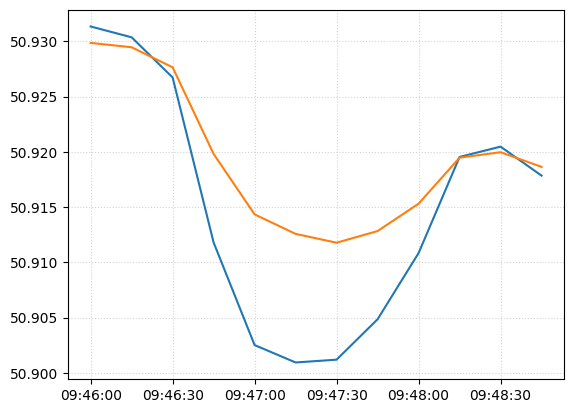

In [360]:
plt.plot(tech_globe.all_new_data_of_multi_time_frames[0][(tech_globe.all_new_data_of_multi_time_frames[0].index>="2024-01-18 09:46:00")*(tech_globe.all_new_data_of_multi_time_frames[0].index<="2024-01-18 09:48:45")][["ema_12", "ema_24"]])

In [267]:
tech_globe.all_new_data_of_multi_time_frames[0].iloc[:, -15:]

,IsBuySignal,IsSellSignal,status,IsLL,IsLH,ll_time,ll_value,IsHH,IsHL,hh_time,hh_value,lh_time,lh_value,hl_time,hl_value
2024-01-18 09:30:00,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,0.0,0.0,NaT,NaN,NaT,NaN,NaT,NaN
2024-01-18 09:30:15,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:30:15,50.828386,NaT,NaN,NaT,NaN
2024-01-18 09:30:30,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:30:30,50.861836,NaT,NaN,NaT,NaN
2024-01-18 09:30:45,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:30:45,50.899629,NaT,NaN,NaT,NaN
2024-01-18 09:31:00,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:00,50.990000,NaT,NaN,NaT,NaN
2024-01-18 09:31:15,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:15,50.991200,NaT,NaN,NaT,NaN
2024-01-18 09:31:30,0.0,0.0,waiting,1.0,0.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:30,50.973057,NaT,NaN,NaT,NaN
2024-01-18 09:31:45,0.0,1.0,waiting,1.0,1.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:15,50.991200,2024-01-18 09:31:45,50.808457,NaT,NaN
2024-01-18 09:32:00,0.0,1.0,waiting,1.0,1.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:15,50.991200,2024-01-18 09:32:00,50.815021,NaT,NaN
2024-01-18 09:32:15,0.0,1.0,waiting,1.0,1.0,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:15,50.991200,2024-01-18 09:32:15,50.809493,NaT,NaN


In [224]:
tech_globe.all_new_data_of_multi_time_frames[0].IsBuySignal

2024-01-18 09:30:00    0.0
2024-01-18 09:30:15    0.0
2024-01-18 09:30:30    0.0
2024-01-18 09:30:45    0.0
2024-01-18 09:31:00    0.0
2024-01-18 09:31:15    0.0
2024-01-18 09:31:30    0.0
2024-01-18 09:31:45    0.0
2024-01-18 09:32:00    0.0
2024-01-18 09:32:15    0.0
2024-01-18 09:32:30    0.0
2024-01-18 09:32:45    0.0
2024-01-18 09:33:00    1.0
2024-01-18 09:33:15    1.0
Name: IsBuySignal, dtype: float64

In [225]:
tech_globe.all_new_data_of_multi_time_frames[0].IsSellSignal

2024-01-18 09:30:00    0.0
2024-01-18 09:30:15    0.0
2024-01-18 09:30:30    0.0
2024-01-18 09:30:45    0.0
2024-01-18 09:31:00    0.0
2024-01-18 09:31:15    0.0
2024-01-18 09:31:30    0.0
2024-01-18 09:31:45    1.0
2024-01-18 09:32:00    1.0
2024-01-18 09:32:15    1.0
2024-01-18 09:32:30    1.0
2024-01-18 09:32:45    1.0
2024-01-18 09:33:00    1.0
2024-01-18 09:33:15    1.0
Name: IsSellSignal, dtype: float64

In [218]:
tech_globe.selected_zig_zag_data.loc[tech_globe.selected_all_new_data.status=='buy', 'pivot_buy_signal']

Series([], Name: pivot_buy_signal, dtype: float64)

In [217]:
tech_globe.selected_zig_zag_data.loc[tech_globe.selected_all_new_data.status=='buy', 'pivot_buy_signal'] = tech_globe.selected_zig_zag_data.loc[tech_globe.selected_all_new_data.status=='buy', 'open']


In [214]:
tech_globe.all_new_data_of_multi_time_frames[0].IsSellSignal

2024-01-18 09:30:00    0.0
2024-01-18 09:30:15    0.0
2024-01-18 09:30:30    0.0
2024-01-18 09:30:45    0.0
2024-01-18 09:31:00    0.0
2024-01-18 09:31:15    0.0
2024-01-18 09:31:30    0.0
2024-01-18 09:31:45    1.0
2024-01-18 09:32:00    1.0
2024-01-18 09:32:15    1.0
2024-01-18 09:32:30    1.0
2024-01-18 09:32:45    1.0
2024-01-18 09:33:00    1.0
2024-01-18 09:33:15    1.0
Name: IsSellSignal, dtype: float64

In [203]:
tech_globe.multi_time_frames_zig_zag_data[0]

,open,high,low,close,date_id,interface,pivots,pivot_price,pivot_ll,pivot_lh,pivot_hh,pivot_hl,pivot_buy_signal,pivot_sell_signal
2024-01-18 09:30:00,50.600000,50.777014,50.596667,50.765986,0,A_1,-2,50.596667,50.596667,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:15,50.767071,50.828386,50.752193,50.816779,1,A_1,0,50.675573,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:30,50.816079,50.861836,50.805000,50.857693,2,A_1,0,50.754480,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:30:45,50.858164,50.899629,50.851971,50.883943,3,A_1,0,50.833387,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:00,50.882814,50.990000,50.871793,50.975993,4,A_1,0,50.912293,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:15,50.978414,50.991200,50.937679,50.955357,5,A_1,2,50.991200,NaN,NaN,50.9912,NaN,NaN,NaN
2024-01-18 09:31:30,50.956686,50.973057,50.877557,50.889836,6,A_1,0,50.899829,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18 09:31:45,50.887379,50.893693,50.808457,50.824664,7,A_1,-1,50.808457,NaN,50.808457,NaN,NaN,NaN,50.887379
2024-01-18 09:32:00,50.824743,50.843471,50.815021,50.835271,8,A_1,0,50.832369,NaN,NaN,NaN,NaN,NaN,50.824743
2024-01-18 09:32:15,50.836021,50.843514,50.809493,50.822014,9,A_1,0,50.856281,NaN,NaN,NaN,NaN,NaN,50.836021


In [204]:
tech_globe.multi_time_frames_all_new_data[1]

,open,high,low,close,date_id,ema_12,ema_24,interface,IsEMACutting,cutting_deg,...,ll_time,ll_value,IsHH,IsHL,hh_time,hh_value,lh_time,lh_value,hl_time,hl_value
2024-01-18 09:30:00,50.600000,50.814050,50.596667,50.800707,0,49.715342,49.595806,A_1,NaN,NaN,...,2024-01-18 09:30:00,50.596667,0.0,0.0,NaT,NaN,NaT,NaN,NaT,NaN
2024-01-18 09:30:20,50.802429,50.840757,50.790050,50.834614,1,49.887538,49.694911,A_1,False,9.770272,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:30:20,50.840757,NaT,NaN,NaT,NaN
2024-01-18 09:30:40,50.834586,50.899629,50.826243,50.883943,2,50.040831,49.790033,A_1,False,8.715203,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:30:40,50.899629,NaT,NaN,NaT,NaN
2024-01-18 09:31:00,50.882814,50.991200,50.871793,50.964729,3,50.182969,49.884009,A_1,False,8.089724,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:00,50.991200,NaT,NaN,NaT,NaN
2024-01-18 09:31:20,50.965979,50.977486,50.926836,50.936850,4,50.298951,49.968236,A_1,False,6.615702,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:20,50.977486,NaT,NaN,NaT,NaN
2024-01-18 09:31:40,50.935679,50.943314,50.808457,50.824664,5,50.379830,50.036750,A_1,False,4.623961,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:40,50.943314,NaT,NaN,NaT,NaN
2024-01-18 09:32:00,50.824743,50.843514,50.814971,50.824350,6,50.448217,50.099758,A_1,False,3.912237,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:00,50.991200,2024-01-18 09:32:00,50.814971,NaT,NaN
2024-01-18 09:32:20,50.824429,50.836829,50.809493,50.831557,7,50.507193,50.158302,A_1,False,3.375128,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:00,50.991200,2024-01-18 09:32:20,50.809493,NaT,NaN
2024-01-18 09:32:40,50.831914,50.871957,50.824471,50.866257,8,50.562433,50.214939,A_1,False,3.161843,...,2024-01-18 09:30:00,50.596667,1.0,0.0,2024-01-18 09:31:00,50.991200,2024-01-18 09:32:40,50.824471,NaT,NaN
2024-01-18 09:33:00,50.868921,50.951929,50.863536,50.946179,9,50.621471,50.273438,A_1,False,3.378690,...,2024-01-18 09:30:00,50.596667,1.0,1.0,2024-01-18 09:31:00,50.991200,2024-01-18 09:32:20,50.809493,2024-01-18 09:33:00,50.951929
